# Libraries

In [1]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from sklearn.utils import class_weight
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys,gc

from sklearn.metrics import confusion_matrix,accuracy_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval
from IPython.display import Image
from IPython.core.display import HTML 

Using TensorFlow backend.


Welcome to the jupyter notebook of the paper **Harnessing the power of CNNs for Light curves usingMarkov Transition Fields**. In this jupyer, it will be demonstrated what was the logical process and the code to reach the conclusions that we achieved in our paper. This jupyte is divided into the following sections:

1) The Tiny Light Curve Pre-processing

# Download Light Curves

For this study, we will use the Kepler mission dataset. This is easily downloadable at [this link](https://exoplanetarchive.ipac.caltech.edu/docs/data.html). We played around with the data a bit to get familiar with the light curves inside the fits.

In [20]:
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)

folder = '/users/gmolina/PIIC19/KOI_Data/sample/'

We will take 3 different fits to extract examples of light curves.

In [21]:
import os

fits_available = os.listdir(folder)
fits_available[:3]

['kplr001026032-20160128150956_dvt.fits',
 'kplr001432214-20160128150956_dvt.fits',
 'kplr001025986-20160128150956_dvt.fits']

In [22]:
a = fits.open(folder+fits_available[0])
b = fits.open(folder+fits_available[1])
c = fits.open(folder+fits_available[2])
print('Data points Light Curve 1: '+str((len(a[1].data.field("LC_INIT")))))
print('Data points Light Curve 2: '+str((len(b[1].data.field("LC_INIT")))))
print('Data points Light Curve 3: '+str((len(c[1].data.field("LC_INIT")))))

Data points Light Curve 1: 71427
Data points Light Curve 2: 71427
Data points Light Curve 3: 71427


As you can see, the curves in this example are the same length, which doesn't necessarily always happen. Now that we have our light curves, let's see what the fits look like in their entirety.

In [23]:
hdulist = fits.open(folder+fits_available[4])
hdulist.info()

Filename: /users/gmolina/PIIC19/KOI_Data/sample/kplr001293031-20160128150956_dvt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  TCE_1         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  TCE_2         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  3  TCE_3         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  4  Statistics    1 BinTableHDU    221   71427R x 50C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


In [24]:
hdulist[1].header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   44 / length of first array dimension                
NAXIS2  =                71427 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   10 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

Many definitions, right? Don't worry, you can find a complete fits tutorial on [this page](https://docs.astropy.org/en/stable/io/fits/). Now, let's plot some parameters.

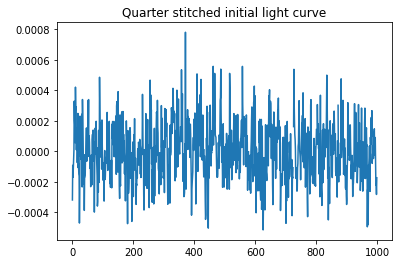

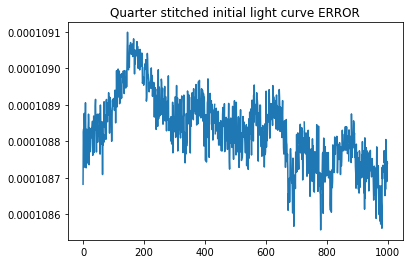

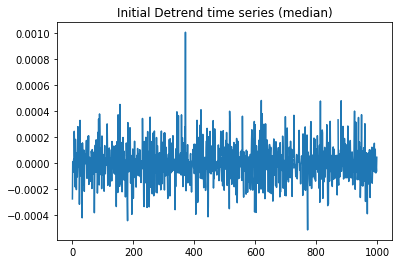

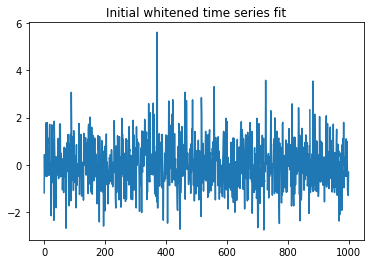

In [25]:
data = hdulist[1].data

time = data.field('TIME')
lc_init = data.field("LC_INIT")
lc_error = data.field("LC_INIT_ERR")
lc_white = data.field("LC_WHITE")
lc_detrend = data.field("LC_DETREND")
time

#plot until
p_n = 1000

hdulist[1].data.field("LC_INIT")

plt.plot(lc_init[:p_n])
plt.title("Quarter stitched initial light curve")
plt.show()

plt.plot(lc_error[:p_n])
plt.title("Quarter stitched initial light curve ERROR")
plt.show()

plt.plot(lc_detrend[:p_n])
plt.title("Initial Detrend time series (median)")
plt.show()

plt.plot(lc_white[:p_n])
plt.title("Initial whitened time series fit")
plt.show()

As you can see, a lot of information can be extracted from the fits, but our research uses light curves more than anything. Now that we know where they come from and how to extract them, let's move on to building the MTF image.

# Light Curve to MTF

## Let's get a little organized

After generating the normalized light curves, we will proceed to create the MTF images. This process is divided into three parts. The first part is the transformation of the light curve as such to an MTF image. The second part is to transform the temporal information of the light curve into a **Sample Detection Curve (SDC)** and then transform this SDC into another MTF image. Finally, the last step is to simply concatenate the light curve MTF and the SDC MTF to combine both the time series information and the light curve time information into a single two-channel image.

First, we load the data and guarantee if we are working with the correct amount of data.

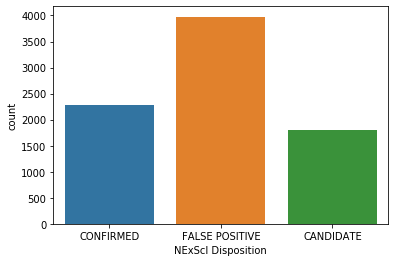

Confirmed: 2281
False Positive: 3976
Candidate: 1797
Total: 8054


In [30]:
df_aux = pd.read_csv("/users/gmolina/PIIC19/KOI_Data/kepler_dataset.csv")
sns.countplot(data=df_aux, x="NExScI Disposition")
plt.show()
print('Confirmed: '+str(df_aux[df_aux["NExScI Disposition"] == "CONFIRMED"]['NExScI Disposition'].count()))
print('False Positive: '+str(df_aux[df_aux["NExScI Disposition"] == "FALSE POSITIVE"]['NExScI Disposition'].count()))
print('Candidate: '+str(df_aux[df_aux["NExScI Disposition"] == "CANDIDATE"]['NExScI Disposition'].count()))
print('Total: '+str(df_aux["NExScI Disposition"].count()))

Now that we know we are working with the correct data, we create the class targets.

In [31]:
labels = (df_aux["NExScI Disposition"] == "CONFIRMED").values*1
print('Total Light Curve: '+ str(labels.shape[0]))

Total Light Curve: 8054


In [32]:
unique, counts = np.unique(labels, return_counts=True)
count = dict(zip(unique, counts))
print('Quantity of class 0: '+str(count[0]))
print('Quantity of class 1: '+str(count[1]))

Quantity of class 0: 5773
Quantity of class 1: 2281


As you can see, we have only two classes, class 0, which is the union between class **False Positives** and class **Candidates** while class 1 is all light curves **Confirmed**. This separation was made so that the network learned the task of classifying light curves with confirmed exo-planets in order to rescue other curves with exo-planets of candidate elements.

Now that we have our data organized, it's time to transform light curves into MTF images.

## From Time Serie to Image

First, let's create the function that transforms any time series into an MTF image. We decided to do this since the libraries that already had this function implemented were too slow for large series and since the Kepler dataset light curves are series of 60,000 data points on average, we decided to create our own function to speed up the transformation. Also, we use [Numba](http://numba.pydata.org/), to further decrease the time of this process.

In [33]:
from numba import njit, jit

def prepare_lc(fluxs): #divide by the min value
    fluxs = np.asarray(fluxs)
    return fluxs/np.abs(np.nanmin(fluxs))

def extract_nans(fluxs, plot=True):
    ###extract the nans and leave stretches of continuous values
    lc_wind_nan = []
    lengths = []

    sublist = [] 
    for value in fluxs:
        if np.isnan(value) and len(sublist) != 0:
            if len(sublist) != 1:
                lc_wind_nan.append(np.asarray(sublist))
                lengths.append(len(sublist))
            sublist = []
        elif np.isnan(value) and len(sublist) == 0:
            continue
        else: #if value not nan
            sublist.append(value) 

    if plot:
        lengths = np.asarray(lengths)   
        print("Cantidad de tramos: ",len(lengths))
        print("Largo promedio de tramos: ", np.mean(lengths))
        print("Mediana de largo de tramos: ", np.median(lengths))
        print("Min de largo de tramos: ", np.min(lengths))
        print("Max de largo de tramos: ", np.max(lengths))
    return lc_wind_nan

@njit(parallel=True, cache=False, fastmath=True)
def det_state(a, b, n_sta):
    topes=np.linspace(a, b, n_sta+1)
    estados= []
    ind=1
    for top in topes[:-1]:
        estados.append((top,topes[ind]))
        ind+=1
    return estados

@njit(parallel=False, cache=True, fastmath=True)
def det_state_2ways(a, b, n_sta_up, n_sta_low):
    estados_up = det_state(a, 0, n_sta_up)
    estados_low = det_state(0, b, n_sta_low)
    return estados_up + estados_low

@njit(parallel=False, cache=True, fastmath=True)
def det_celda(num, estados): 
    for celda, (est_low, est_up) in enumerate(estados):
        if num<est_low and num>=est_up:
            return celda
    return 0 #if sale por arriba (mayor a 1)

@njit(parallel=False, cache=True, fastmath=True)
def add_transitions(fluxs, transition_m, states):
    for ind in range(1,len(fluxs)):
        init_s = det_celda(fluxs[ind-1], states)
        fin_s = det_celda(fluxs[ind], states)
        transition_m[init_s, fin_s] += 1
    return transition_m

@njit(parallel=True, cache=False, fastmath=True)
def manual_HMM(wind_fluxs, n_sta_up, n_sta_low=0):
    if n_sta_low == 0: 
        n_sta_low = n_sta_up 
    n_sta = n_sta_up+n_sta_low
    
    transition_m = np.zeros((n_sta,n_sta))
    
    states = det_state_2ways(1,-1, n_sta_up=n_sta_up, n_sta_low=n_sta_low) 
    for fluxs in wind_fluxs:
        add_transitions(fluxs, transition_m, states)
    
    for i in range(n_sta):
        suma_i = 0
        for j in range(n_sta):
            transition_m[i,j] +=1 #priors
            suma_i += transition_m[i,j]
        transition_m[i] = transition_m[i]/suma_i #normalize
    return transition_m


In [35]:
from pre_process import clean_LC
time_kepler = np.load('/work/work_teamEXOPLANET/KOI_LC/npy/KOI_LC_time.npy') 
our_process = np.load('/work/work_teamEXOPLANET/KOI_LC/cleaned/LC_kepler_processed.npy')

Once the functions are done, we proceed to load and pre-process our light curves. As you may have noticed, we have our own function for pre-processing. To keep a jupyter clean, we decided not to include the preprocessing codes, but the code take each light curve and:

1. Apply a polynomial fit (Savgol filter) of 2 degrees, with a window of 151, and subtract it to the light curve.
2. Apply and subtract a moving median filter, with a window of 25.
3. Remove positive outliers that are high than 5σ and negative outliers lower 290 than 40σ. With σ the standard deviation of the light curve.

We invite the reader to look at [the code](https://github.com/Buguemar/PIIC19/blob/master/code/pre_process.py) if he finds it necessary.

In [36]:
det_state_2ways(1,-1, n_sta_up=16, n_sta_low=16)

<ipython-input-33-deb9cef499e9>:43: NumbaWarning: Cannot cache compiled function "det_state_2ways" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(parallel=False, cache=True, fastmath=True)


[(1.0, 0.9375),
 (0.9375, 0.875),
 (0.875, 0.8125),
 (0.8125, 0.75),
 (0.75, 0.6875),
 (0.6875, 0.625),
 (0.625, 0.5625),
 (0.5625, 0.5),
 (0.5, 0.4375),
 (0.4375, 0.375),
 (0.375, 0.3125),
 (0.3125, 0.25),
 (0.25, 0.1875),
 (0.1875, 0.125),
 (0.125, 0.0625),
 (0.0625, 0.0),
 (-0.0, -0.0625),
 (-0.0625, -0.125),
 (-0.125, -0.1875),
 (-0.1875, -0.25),
 (-0.25, -0.3125),
 (-0.3125, -0.375),
 (-0.375, -0.4375),
 (-0.4375, -0.5),
 (-0.5, -0.5625),
 (-0.5625, -0.625),
 (-0.625, -0.6875),
 (-0.6875, -0.75),
 (-0.75, -0.8125),
 (-0.8125, -0.875),
 (-0.875, -0.9375),
 (-0.9375, -1.0)]

In [37]:
fluxs = our_process[1]
fluxs = prepare_lc(fluxs) #divide by min
lc_tramos =  extract_nans(fluxs) #extract nans
lc_tramos 

Cantidad de tramos:  707
Largo promedio de tramos:  77.06506364922207
Mediana de largo de tramos:  72.0
Min de largo de tramos:  2
Max de largo de tramos:  146


[array([-0.03325527,  0.06651054, -0.01259155,  0.48070119, -0.09846492,
        -0.10887914,  0.23371963,  0.7424305 ,  0.17766037, -0.16148807,
        -0.39734154, -0.13562083,  0.41074358, -0.3037964 , -0.28808495,
        -0.38797703, -0.09234429,  0.06391086,  0.22507561,  0.18266449,
        -0.67473156, -0.0387865 ,  0.18021355,  0.03830472,  0.25399658,
         0.04620247,  0.05829212]),
 array([ 1.46511445e-01,  1.28756979e-01,  7.09038145e-01, -5.88082961e-02,
        -9.49616336e-03, -1.82957226e-01,  4.81780375e-04, -1.82632296e-01,
        -2.74673373e-01, -2.57620363e-01,  3.35196347e-02,  2.25290721e-01,
        -1.24895141e-01,  1.78607545e-02, -2.09664174e-01, -2.30957816e-01,
         1.58031942e-01, -2.04078695e-01,  1.02567918e-01,  3.21394436e-03,
        -3.21394436e-03,  8.91868987e-02, -2.68945014e-01, -7.29039843e-02,
        -1.91280806e-03, -3.88250471e-02,  1.28254261e-01,  0.00000000e+00,
         2.08706381e-01, -7.73916063e-02, -4.25669269e-01, -4.02194

In [39]:
transition_m = manual_HMM(lc_tramos, n_sta_up=16, n_sta_low=16) 

Now that we have our first MTF images we can observe the behavior of some types of light curves.

In [41]:
from fold import phase_fold_and_sort_light_curve, global_view
#plot function
def global_fold(t, fluxs, per, t0, T=1000):
    t_fold, val_fold = phase_fold_and_sort_light_curve(t, fluxs, period= per, t0= t0)
    return global_view(t_fold, val_fold, period=per, num_bins=T, bin_width_factor=1 / T)

### False Postiviso Behavior

In [42]:
falsos_pos=df_aux.loc[df_aux['NExScI Disposition']=='FALSE POSITIVE']
index_fp=list(falsos_pos.index)
len(index_fp)

our_detrends=our_process[index_fp]

Restoring Curve 1
Cantidad de tramos:  707
Largo promedio de tramos:  77.06506364922207
Mediana de largo de tramos:  72.0
Min de largo de tramos:  2
Max de largo de tramos:  146


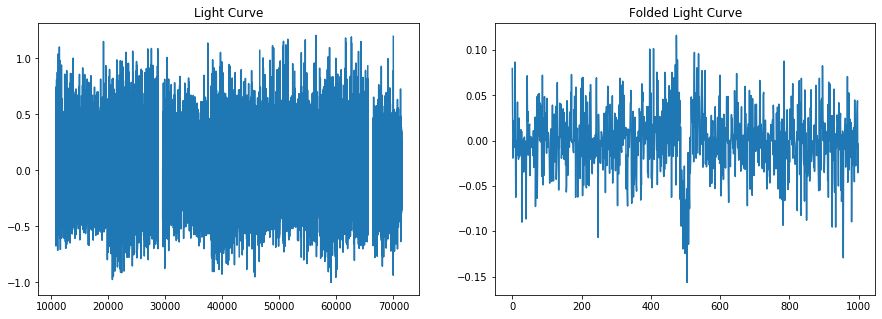

Cantidad de tramos:  708
Largo promedio de tramos:  77.03672316384181
Mediana de largo de tramos:  72.0
Min de largo de tramos:  2
Max de largo de tramos:  146


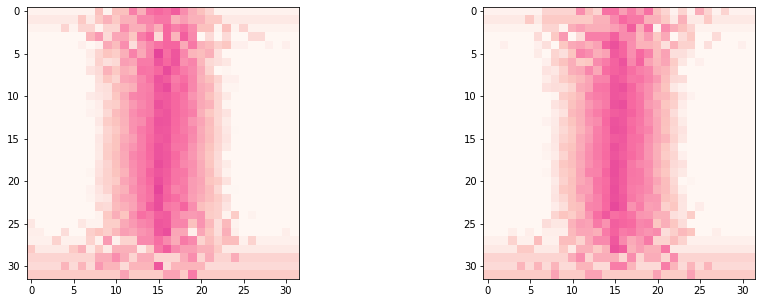

Restoring Curve 2
Cantidad de tramos:  803
Largo promedio de tramos:  79.91158156911581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


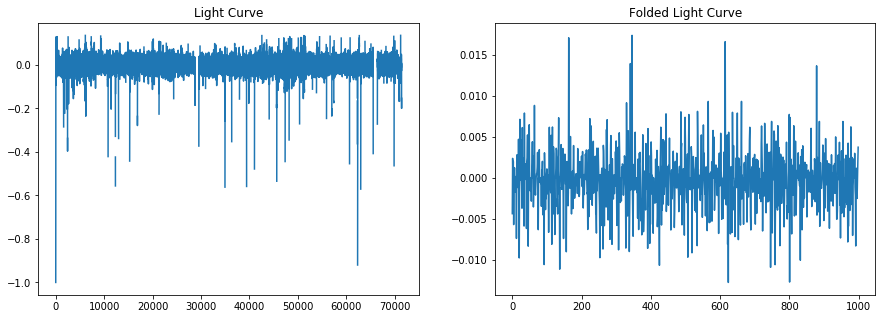

Cantidad de tramos:  804
Largo promedio de tramos:  79.88308457711443
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


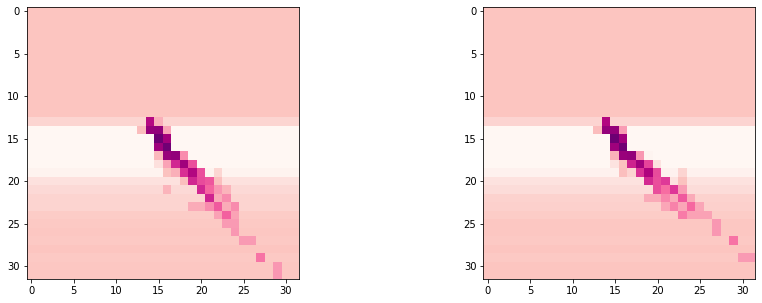

Restoring Curve 3
Cantidad de tramos:  788
Largo promedio de tramos:  81.66116751269035
Mediana de largo de tramos:  84.0
Min de largo de tramos:  2
Max de largo de tramos:  146


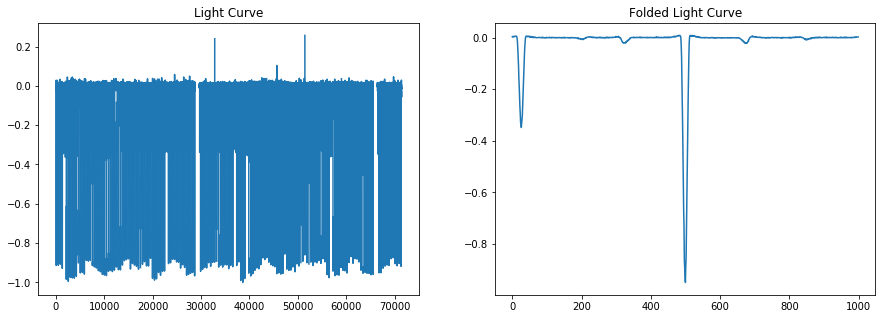

Cantidad de tramos:  788
Largo promedio de tramos:  81.55456852791878
Mediana de largo de tramos:  84.0
Min de largo de tramos:  2
Max de largo de tramos:  146


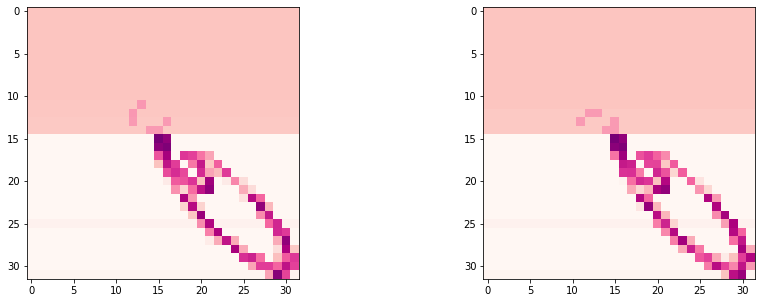

Restoring Curve 4
Cantidad de tramos:  806
Largo promedio de tramos:  79.8089330024814
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


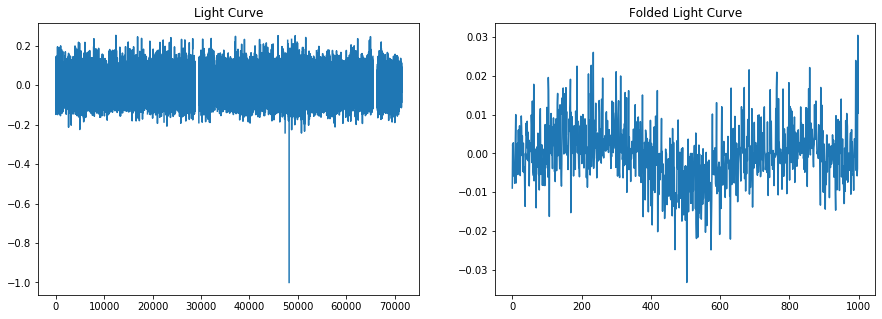

Cantidad de tramos:  806
Largo promedio de tramos:  79.70471464019852
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


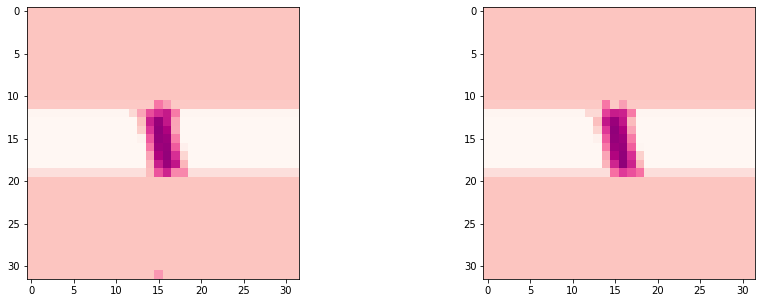

Restoring Curve 5
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


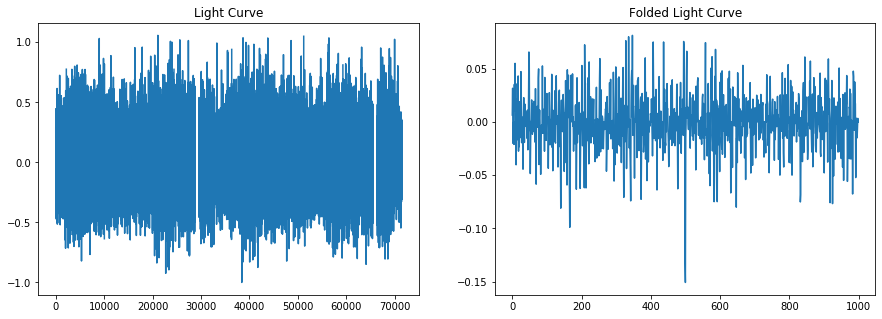

Cantidad de tramos:  807
Largo promedio de tramos:  79.61214374225527
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


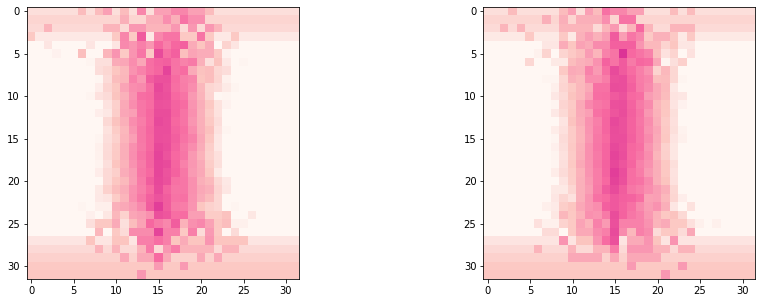

Restoring Curve 6
Cantidad de tramos:  772
Largo promedio de tramos:  81.25388601036269
Mediana de largo de tramos:  84.0
Min de largo de tramos:  2
Max de largo de tramos:  146


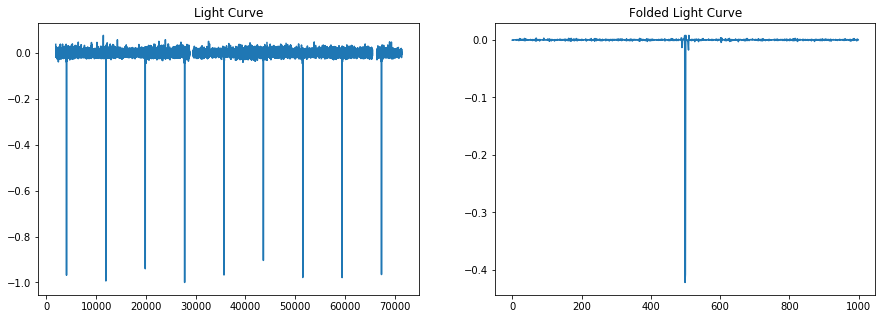

Cantidad de tramos:  773
Largo promedio de tramos:  81.22250970245796
Mediana de largo de tramos:  84.0
Min de largo de tramos:  2
Max de largo de tramos:  146


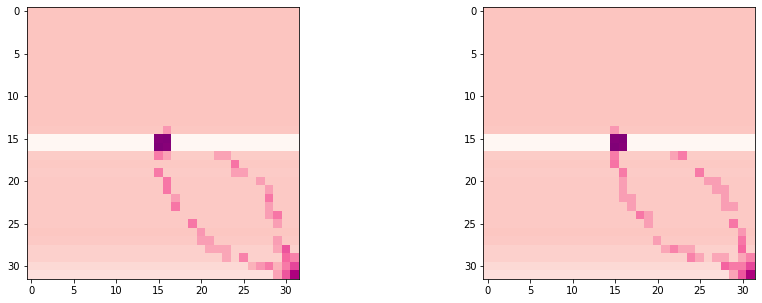

Restoring Curve 7
Cantidad de tramos:  801
Largo promedio de tramos:  80.31710362047441
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


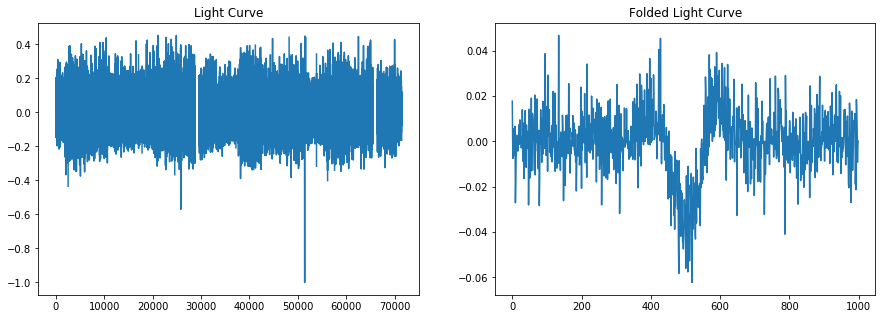

Cantidad de tramos:  801
Largo promedio de tramos:  80.21223470661673
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


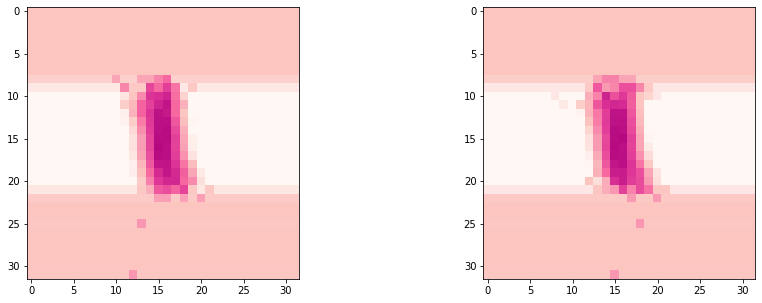

Restoring Curve 8
Cantidad de tramos:  467
Largo promedio de tramos:  63.19700214132762
Mediana de largo de tramos:  36.0
Min de largo de tramos:  2
Max de largo de tramos:  145


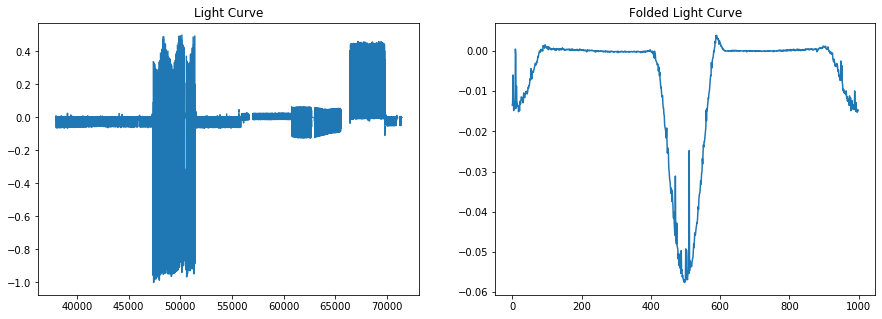

Cantidad de tramos:  468
Largo promedio de tramos:  63.18376068376068
Mediana de largo de tramos:  36.5
Min de largo de tramos:  2
Max de largo de tramos:  145


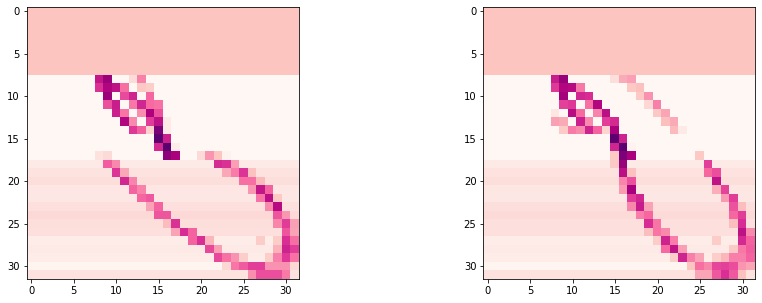

Restoring Curve 9
Cantidad de tramos:  254
Largo promedio de tramos:  89.71259842519684
Mediana de largo de tramos:  97.0
Min de largo de tramos:  2
Max de largo de tramos:  146


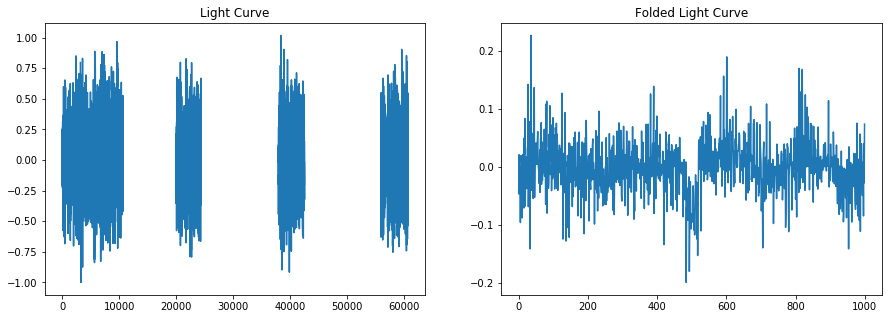

Cantidad de tramos:  253
Largo promedio de tramos:  89.5098814229249
Mediana de largo de tramos:  97.0
Min de largo de tramos:  2
Max de largo de tramos:  146


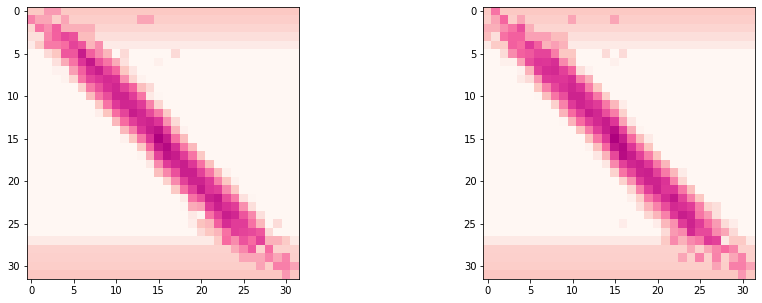

Restoring Curve 10
Cantidad de tramos:  807
Largo promedio de tramos:  79.70260223048327
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


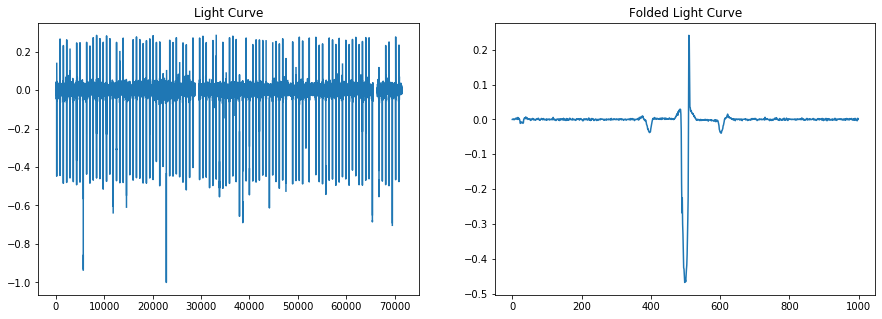

Cantidad de tramos:  807
Largo promedio de tramos:  79.59851301115242
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


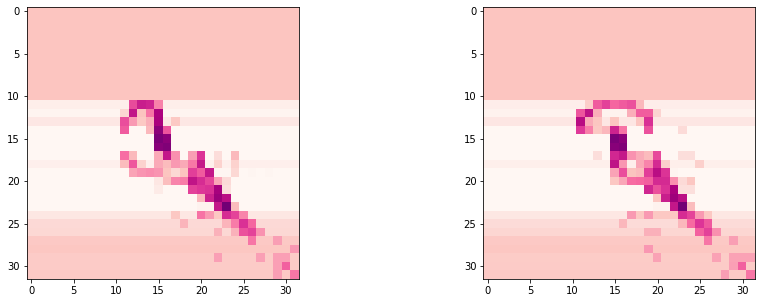

Restoring Curve 11
Cantidad de tramos:  107
Largo promedio de tramos:  80.53271028037383
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  145


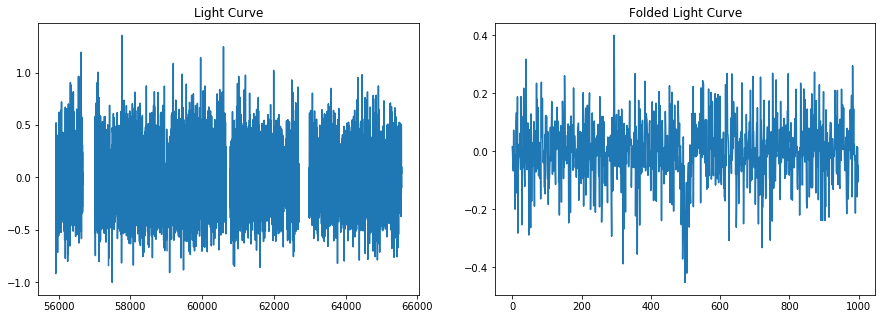

Cantidad de tramos:  107
Largo promedio de tramos:  80.53271028037383
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  145


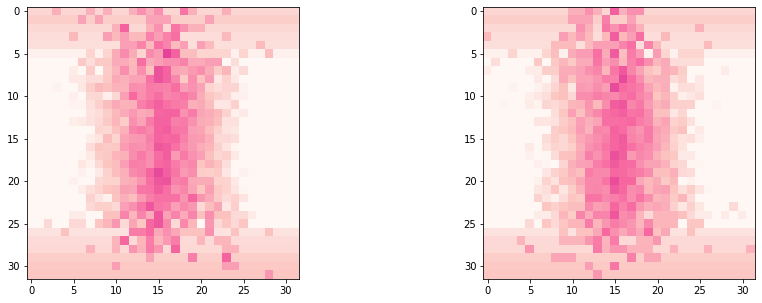

Restoring Curve 12
Cantidad de tramos:  654
Largo promedio de tramos:  83.39908256880734
Mediana de largo de tramos:  90.0
Min de largo de tramos:  2
Max de largo de tramos:  149


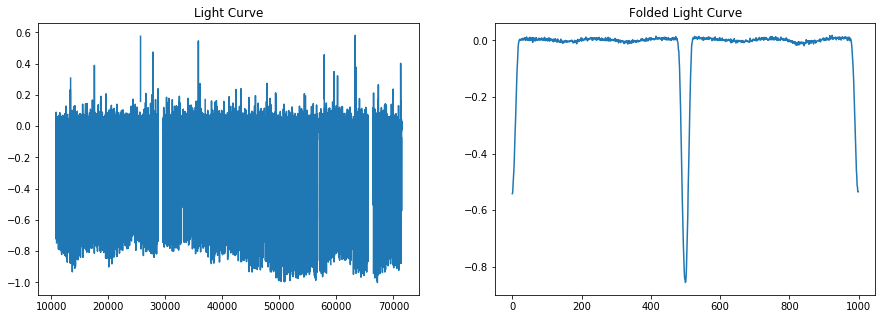

Cantidad de tramos:  655
Largo promedio de tramos:  83.3587786259542
Mediana de largo de tramos:  90.0
Min de largo de tramos:  2
Max de largo de tramos:  149


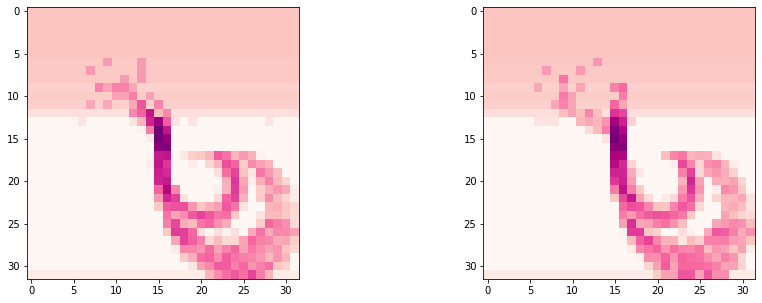

Restoring Curve 13
Cantidad de tramos:  929
Largo promedio de tramos:  64.84391819160388
Mediana de largo de tramos:  54.0
Min de largo de tramos:  2
Max de largo de tramos:  146


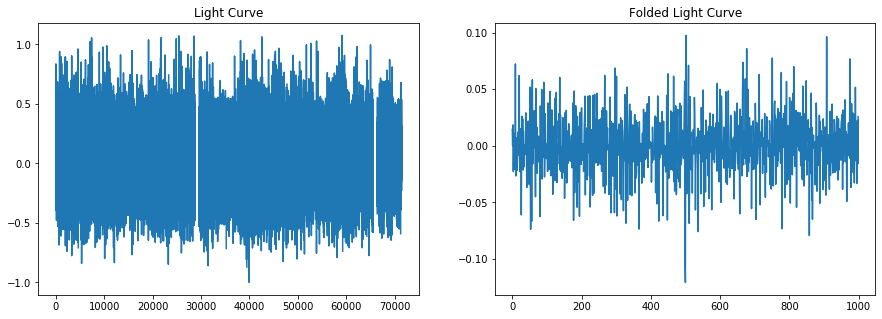

Cantidad de tramos:  929
Largo promedio de tramos:  64.7534983853606
Mediana de largo de tramos:  54.0
Min de largo de tramos:  2
Max de largo de tramos:  146


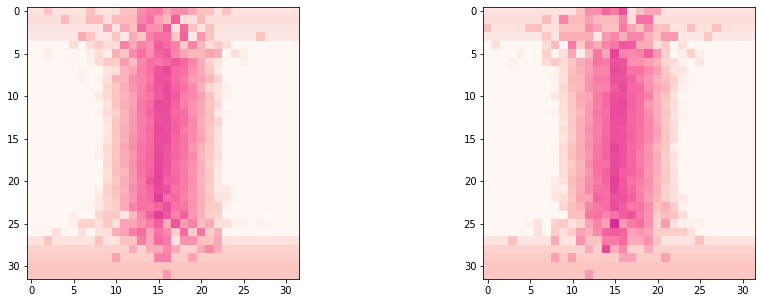

Restoring Curve 14
Cantidad de tramos:  812
Largo promedio de tramos:  79.20689655172414
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  146


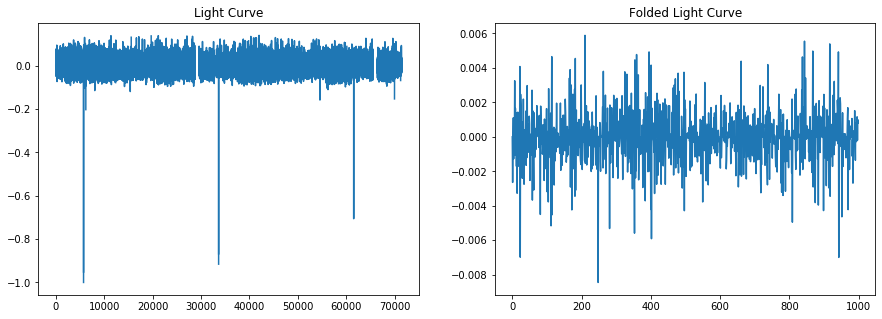

Cantidad de tramos:  812
Largo promedio de tramos:  79.10344827586206
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  146


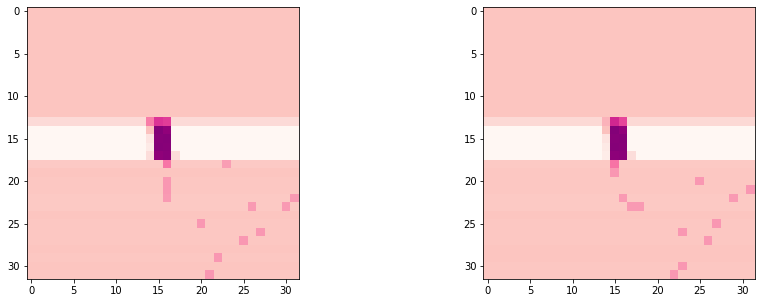

Restoring Curve 15
Cantidad de tramos:  836
Largo promedio de tramos:  76.91866028708134
Mediana de largo de tramos:  73.0
Min de largo de tramos:  2
Max de largo de tramos:  146


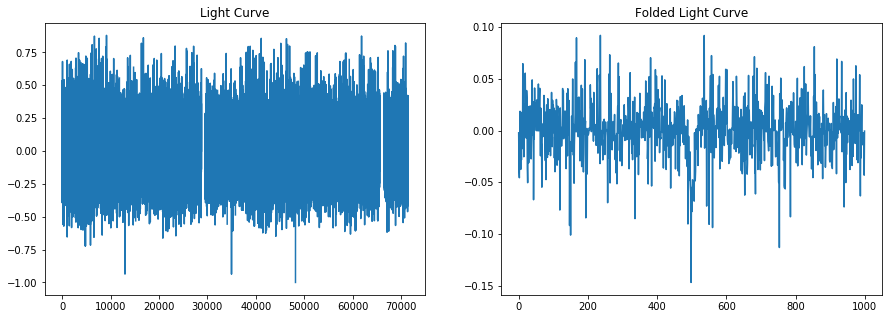

Cantidad de tramos:  836
Largo promedio de tramos:  76.81818181818181
Mediana de largo de tramos:  72.5
Min de largo de tramos:  2
Max de largo de tramos:  146


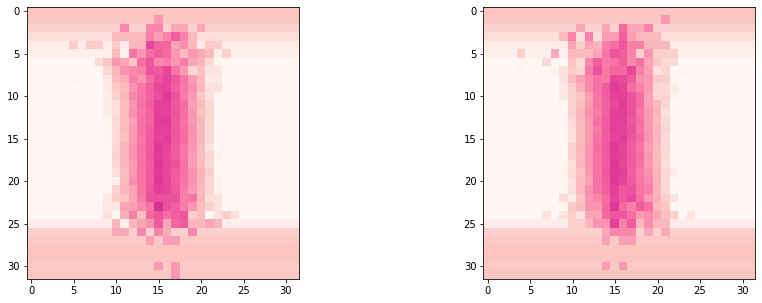

Restoring Curve 16
Cantidad de tramos:  393
Largo promedio de tramos:  86.94402035623409
Mediana de largo de tramos:  93.0
Min de largo de tramos:  2
Max de largo de tramos:  149


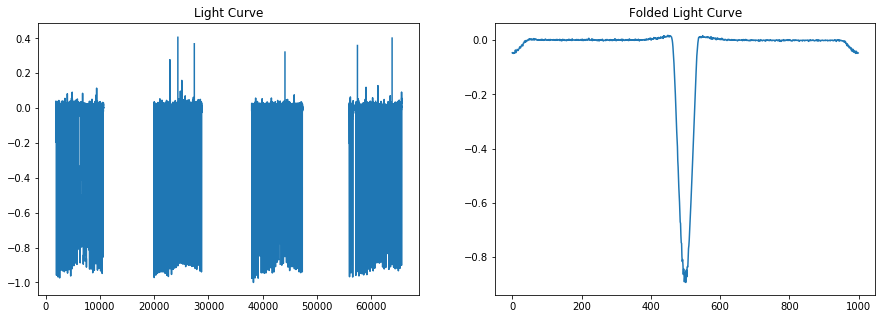

Cantidad de tramos:  393
Largo promedio de tramos:  86.94402035623409
Mediana de largo de tramos:  93.0
Min de largo de tramos:  2
Max de largo de tramos:  149


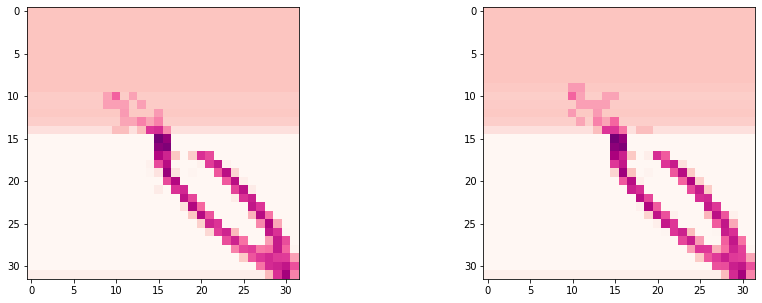

Restoring Curve 17
Cantidad de tramos:  828
Largo promedio de tramos:  77.73188405797102
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


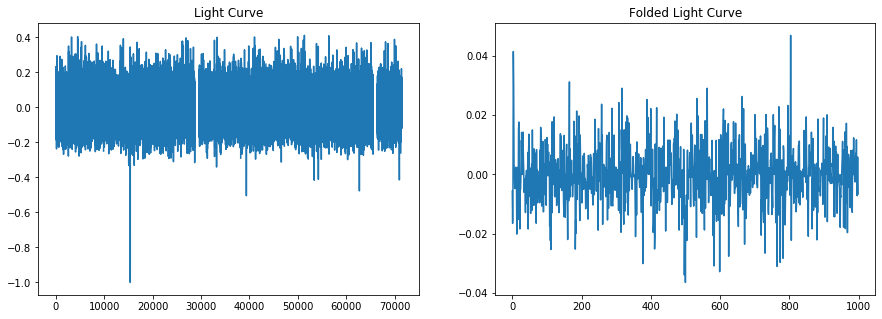

Cantidad de tramos:  827
Largo promedio de tramos:  77.65538089480049
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


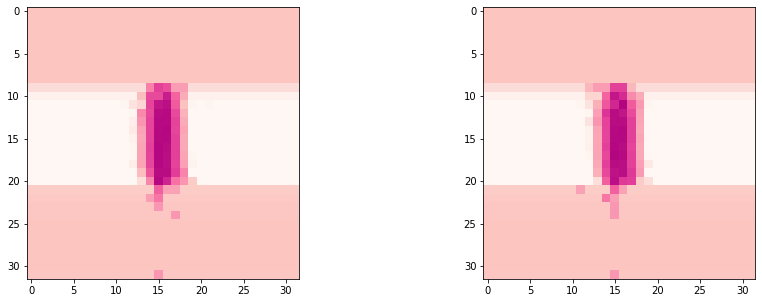

Restoring Curve 18
Cantidad de tramos:  831
Largo promedio de tramos:  77.38989169675091
Mediana de largo de tramos:  73.0
Min de largo de tramos:  2
Max de largo de tramos:  149


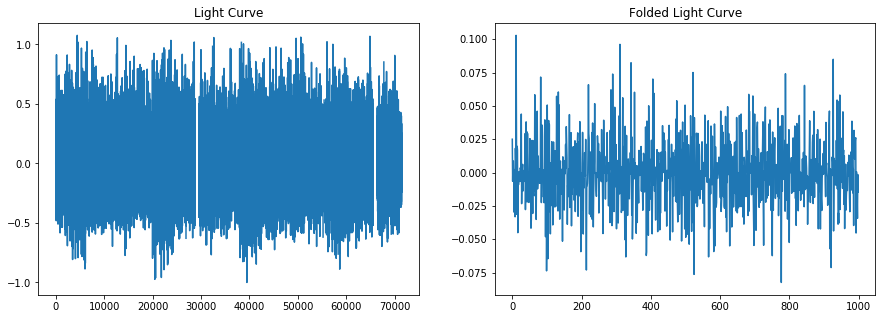

Cantidad de tramos:  831
Largo promedio de tramos:  77.4043321299639
Mediana de largo de tramos:  73.0
Min de largo de tramos:  2
Max de largo de tramos:  149


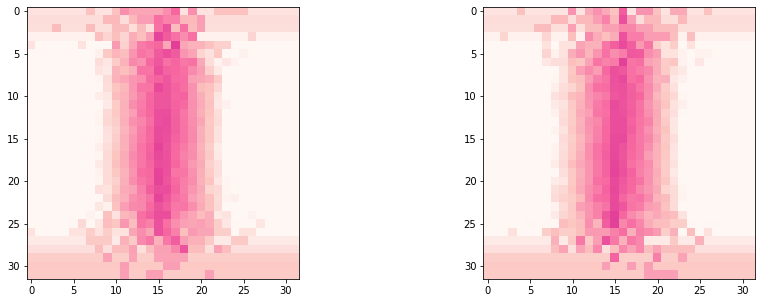

Restoring Curve 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.81617647058823
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


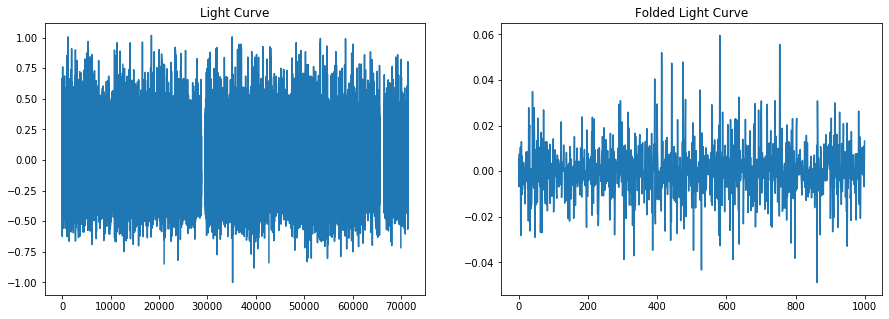

Cantidad de tramos:  816
Largo promedio de tramos:  78.71323529411765
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


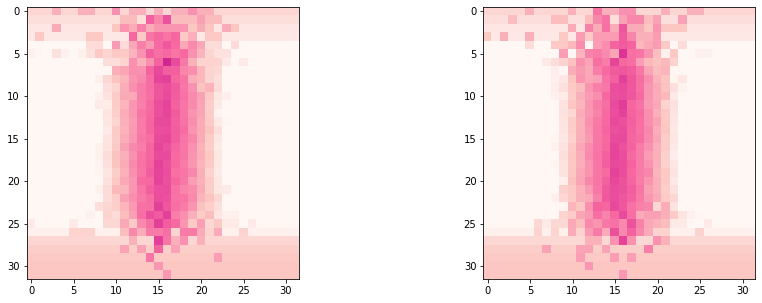

Restoring Curve 20
Cantidad de tramos:  777
Largo promedio de tramos:  80.71685971685972
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


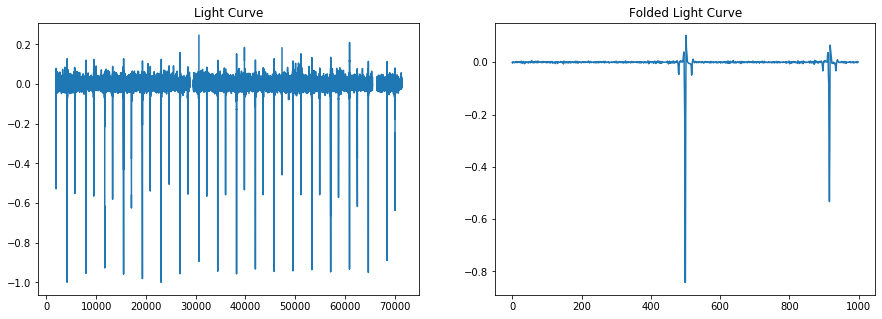

Cantidad de tramos:  778
Largo promedio de tramos:  80.68637532133675
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


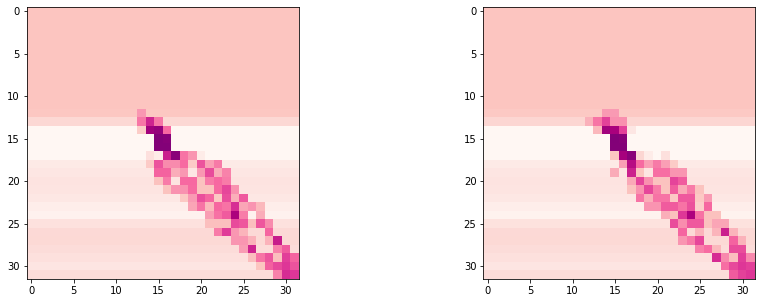

In [43]:
from matplotlib.colors import LogNorm


i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("Restoring Curve",i+1)
    fluxs = prepare_lc(lc_our_detrend) 
    lc_tramos =  extract_nans(fluxs) 
    
    per, t0 = df_aux[["Period", "Time of Transit Epoch"]].values[index_fp][i]
    mask_v = ~np.isnan(fluxs)
    f_glo = global_fold(time_kepler[index_fp][i][mask_v], fluxs[mask_v], per, t0)
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    axx[0].plot(fluxs)
    axx[0].set_title("Light Curve")
    axx[1].plot(f_glo)
    axx[1].set_title("Folded Light Curve")
    plt.show()
    del mask_v,f_glo
    gc.collect()

    transition_m = manual_HMM(lc_tramos, n_sta_up=16, n_sta_low=16) 

    i+=1
    
    labels_x = [str(value) for value in np.arange(0,transition_m.shape[0],2)]
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    axx[0].imshow(transition_m, cmap='RdPu',norm=LogNorm(vmin=0.01, vmax=1)) 
    #axx[0].set_xticklabels(labels_x)
    #axx[0].set_yticklabels(labels_x)

    fluxs = prepare_lc(lc_our_detrend[::-1]) 
    lc_tramos =  extract_nans(fluxs) 
    transition_m = manual_HMM(lc_tramos, n_sta_up=16, n_sta_low=16) 
    
    axx[1].imshow(transition_m, cmap='RdPu',norm=LogNorm(vmin=0.01, vmax=1)) 
    #axx[1].set_xticklabels(labels_x)
    #axx[1].set_yticklabels(labels_x)
    
    plt.show()

### Confirmed Behavior

In [44]:
confirmados=df_aux.loc[df_aux['NExScI Disposition']=='CONFIRMED']
index_con=list(confirmados.index)
our_detrends=our_process[index_con]
len(index_con)

2281

Restoring Curve 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


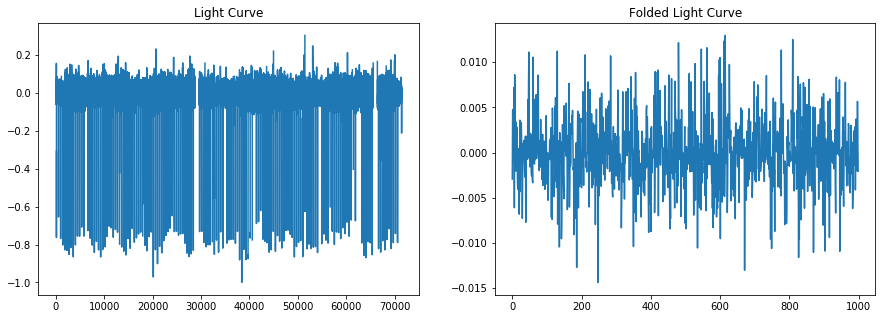

Cantidad de tramos:  796
Largo promedio de tramos:  80.72110552763819
Mediana de largo de tramos:  78.5
Min de largo de tramos:  2
Max de largo de tramos:  149


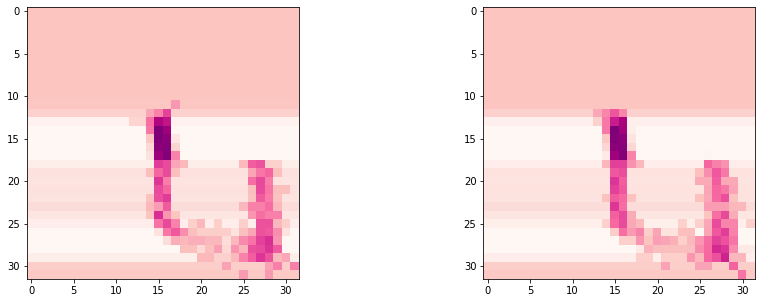

Restoring Curve 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


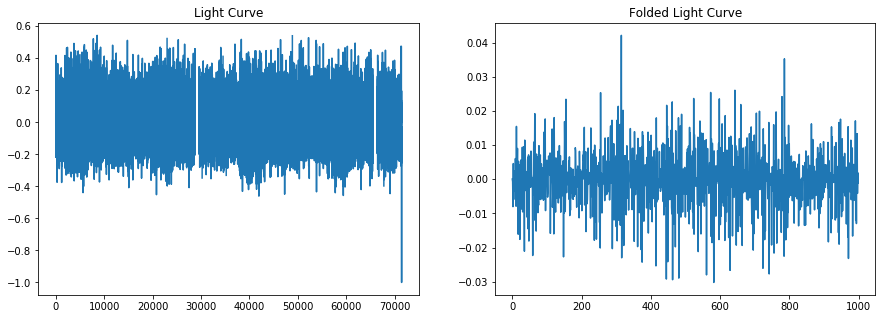

Cantidad de tramos:  807
Largo promedio de tramos:  79.61214374225527
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


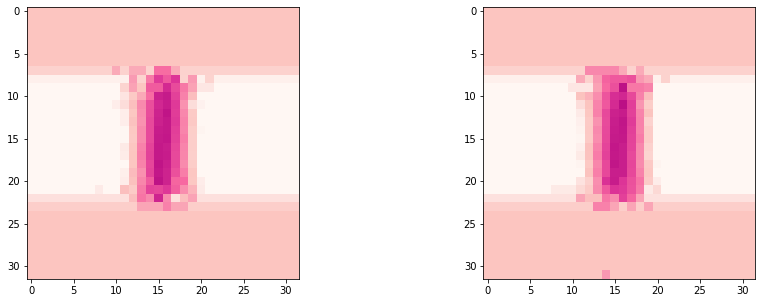

Restoring Curve 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


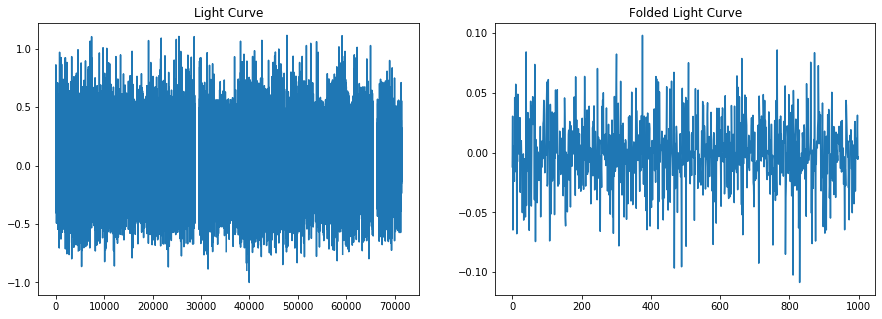

Cantidad de tramos:  822
Largo promedio de tramos:  78.13990267639903
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


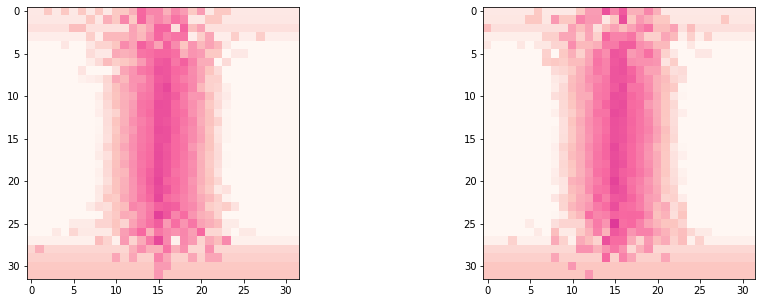

Restoring Curve 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


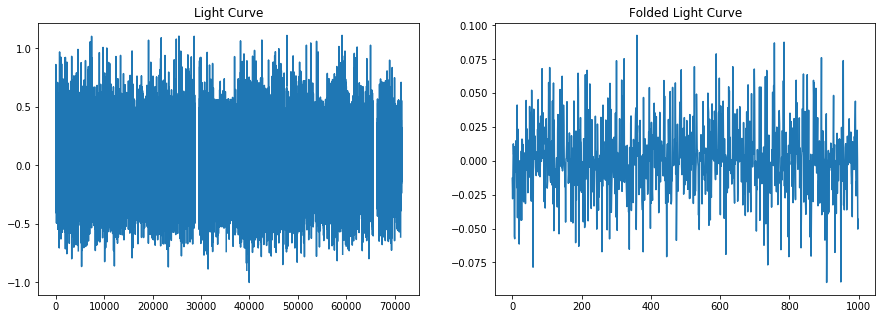

Cantidad de tramos:  863
Largo promedio de tramos:  72.83429895712631
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


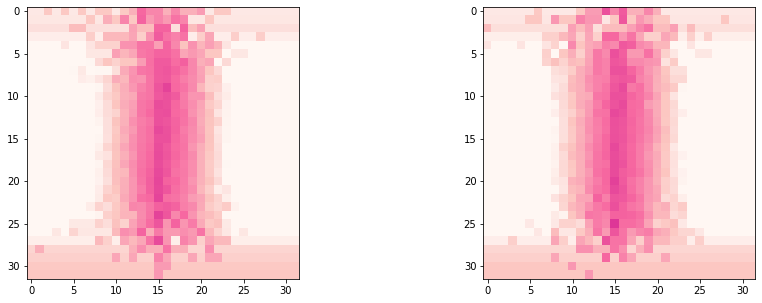

Restoring Curve 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


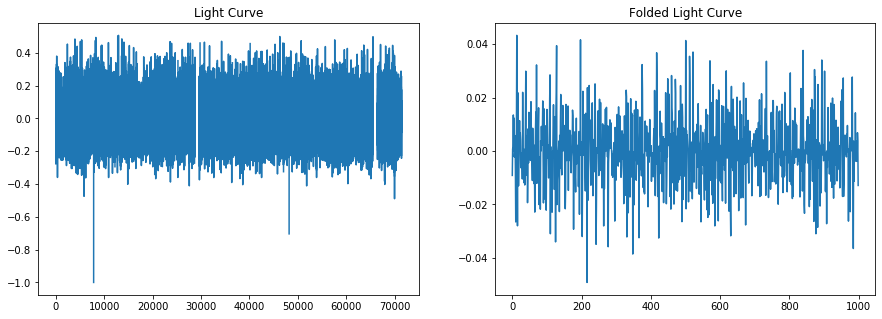

Cantidad de tramos:  824
Largo promedio de tramos:  77.94902912621359
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


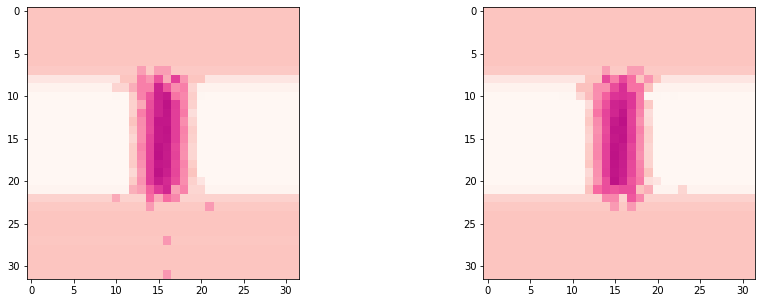

Restoring Curve 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


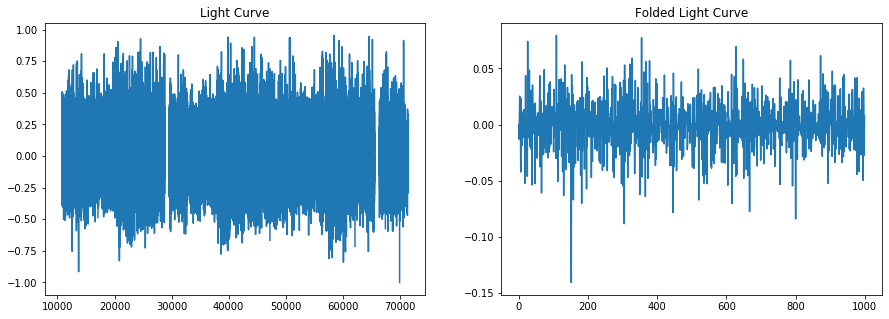

Cantidad de tramos:  681
Largo promedio de tramos:  80.12922173274596
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  146


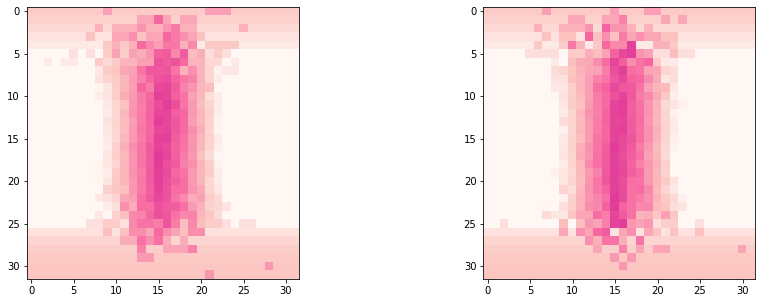

Restoring Curve 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


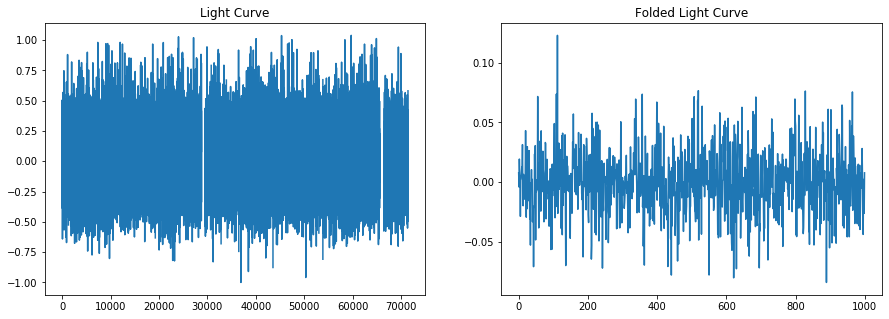

Cantidad de tramos:  843
Largo promedio de tramos:  76.16488730723606
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


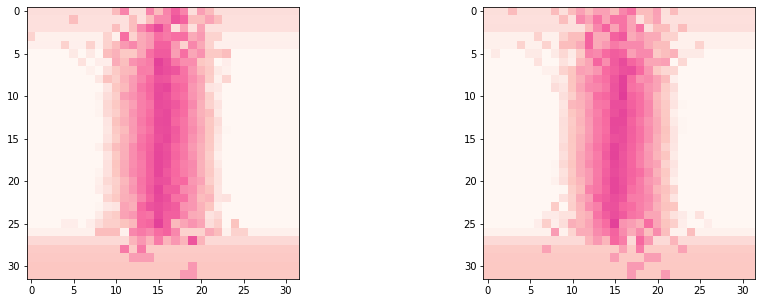

Restoring Curve 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


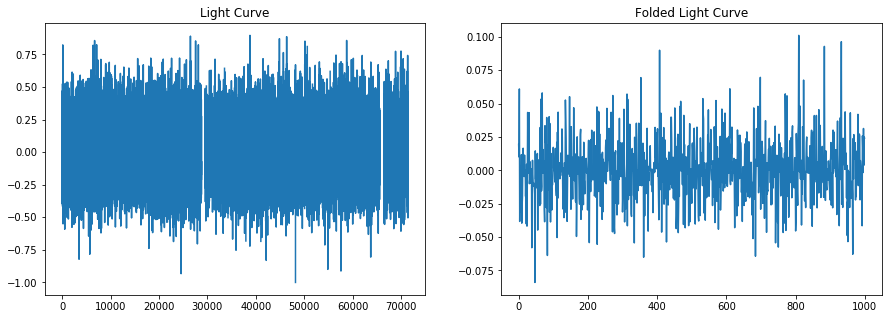

Cantidad de tramos:  818
Largo promedio de tramos:  78.52444987775061
Mediana de largo de tramos:  77.5
Min de largo de tramos:  2
Max de largo de tramos:  149


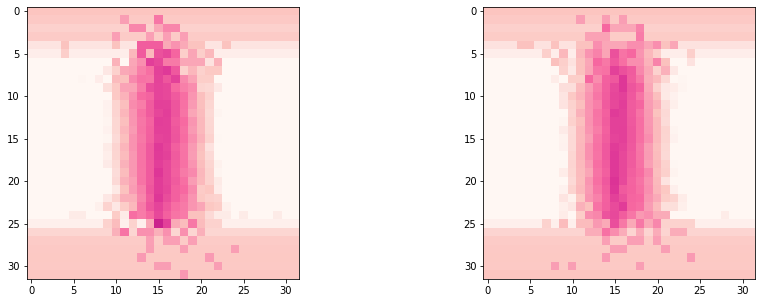

Restoring Curve 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


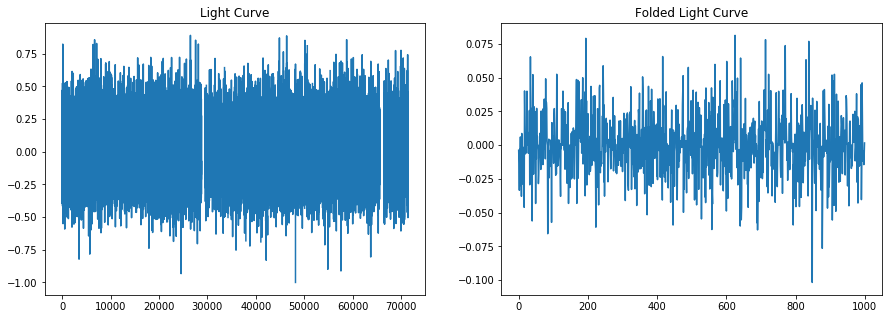

Cantidad de tramos:  822
Largo promedio de tramos:  74.88199513381996
Mediana de largo de tramos:  69.0
Min de largo de tramos:  2
Max de largo de tramos:  149


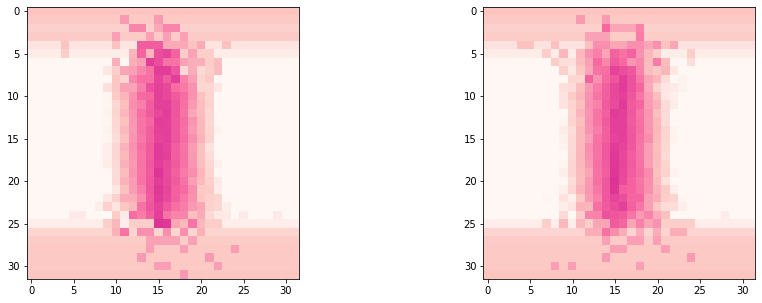

Restoring Curve 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


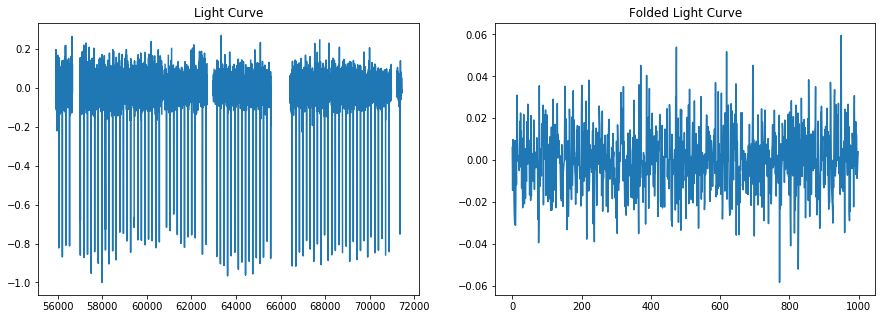

Cantidad de tramos:  161
Largo promedio de tramos:  81.8944099378882
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


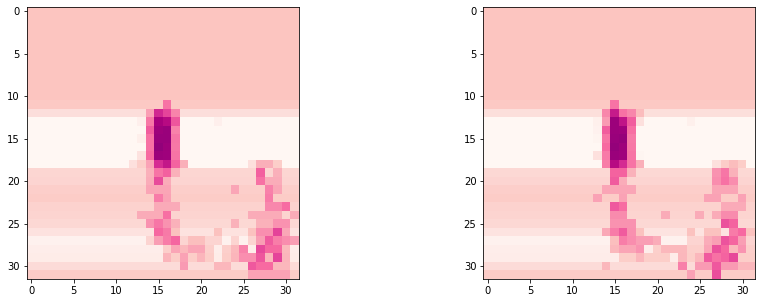

Restoring Curve 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


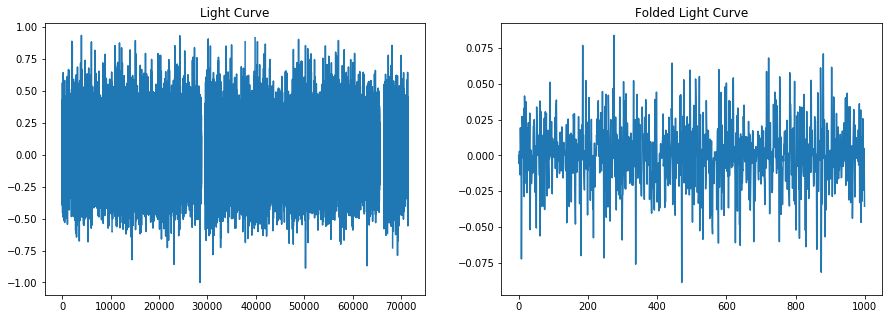

Cantidad de tramos:  815
Largo promedio de tramos:  78.82208588957056
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


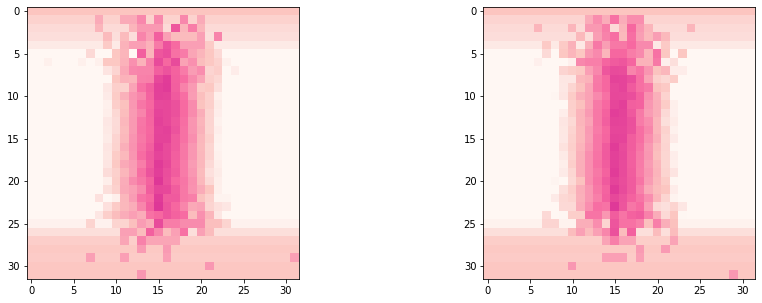

Restoring Curve 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


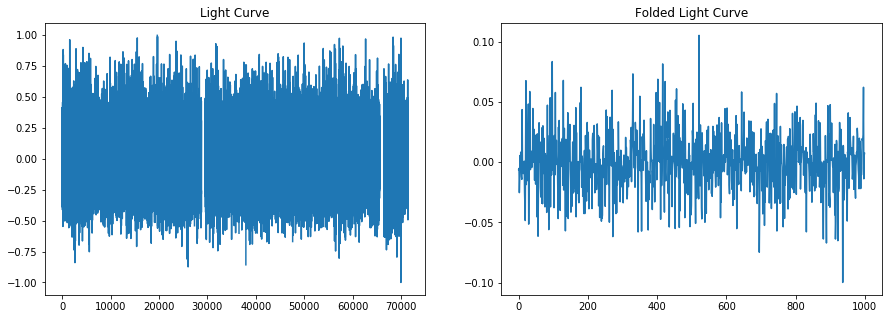

Cantidad de tramos:  825
Largo promedio de tramos:  77.8460606060606
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


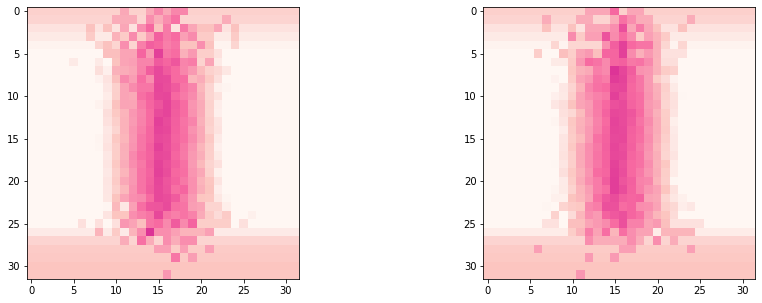

Restoring Curve 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


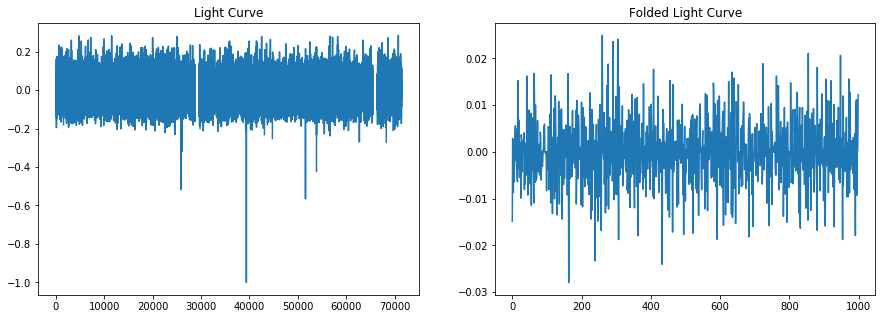

Cantidad de tramos:  831
Largo promedio de tramos:  77.28038507821901
Mediana de largo de tramos:  73.0
Min de largo de tramos:  2
Max de largo de tramos:  149


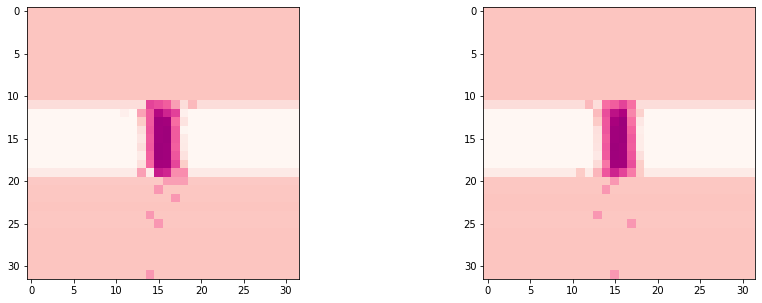

Restoring Curve 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


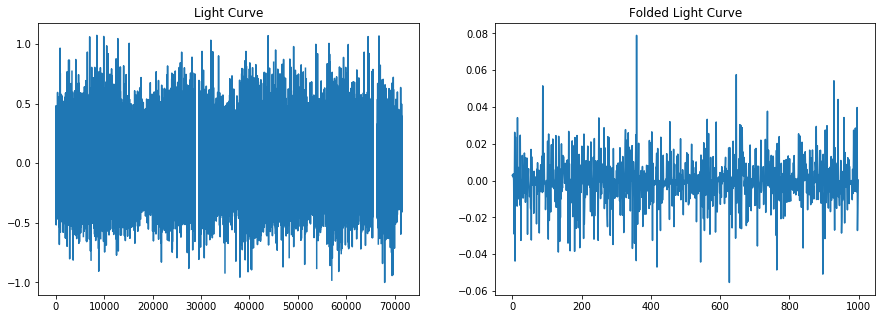

Cantidad de tramos:  801
Largo promedio de tramos:  80.21722846441948
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


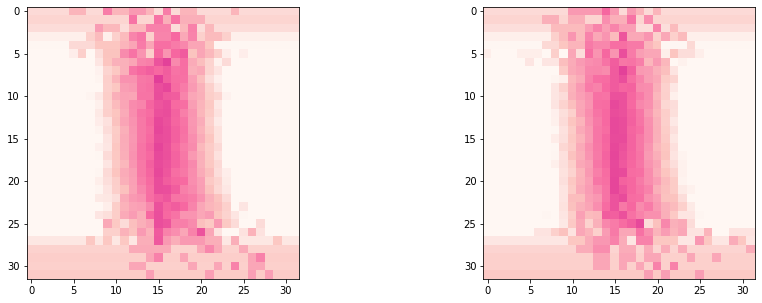

Restoring Curve 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


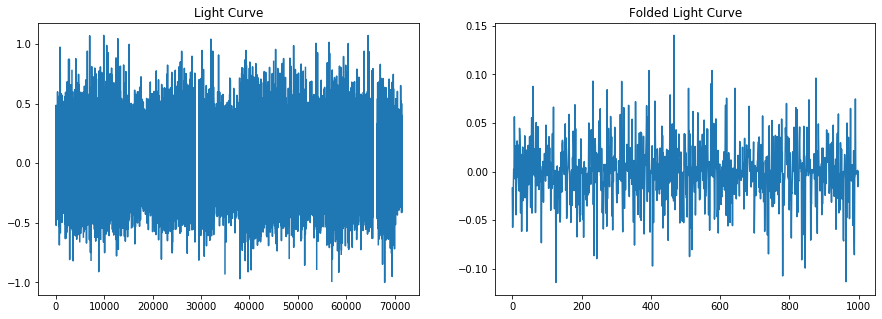

Cantidad de tramos:  857
Largo promedio de tramos:  72.34889148191365
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


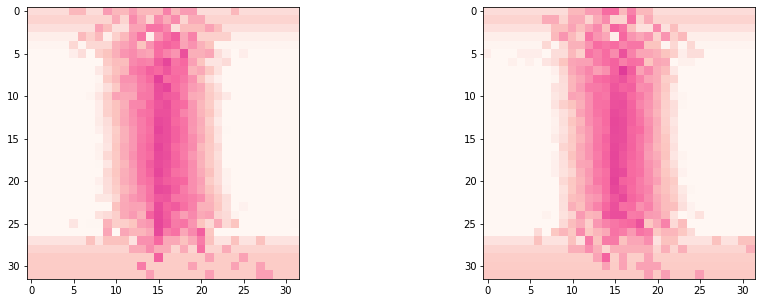

Restoring Curve 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


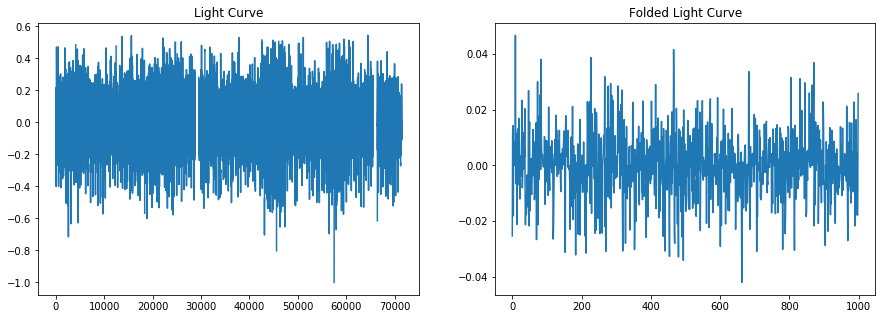

Cantidad de tramos:  812
Largo promedio de tramos:  79.08004926108374
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


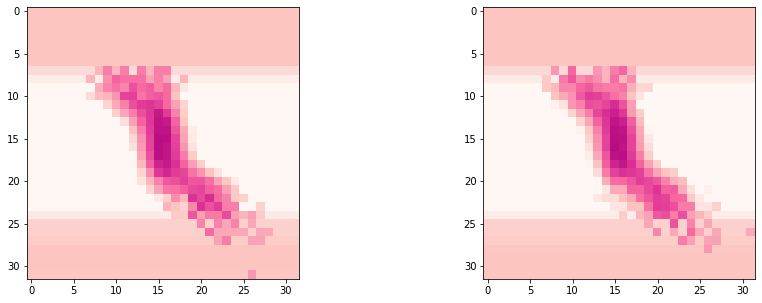

Restoring Curve 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


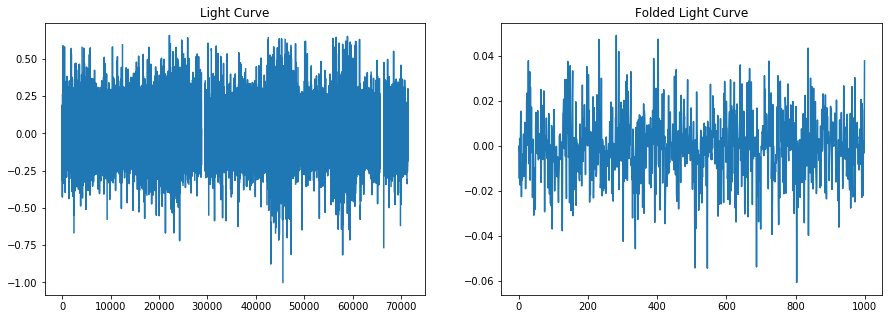

Cantidad de tramos:  912
Largo promedio de tramos:  67.90131578947368
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


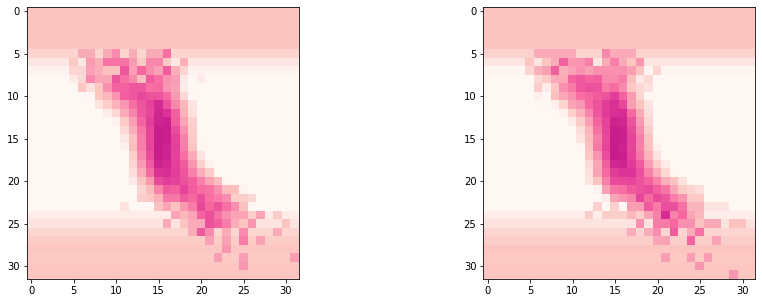

Restoring Curve 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


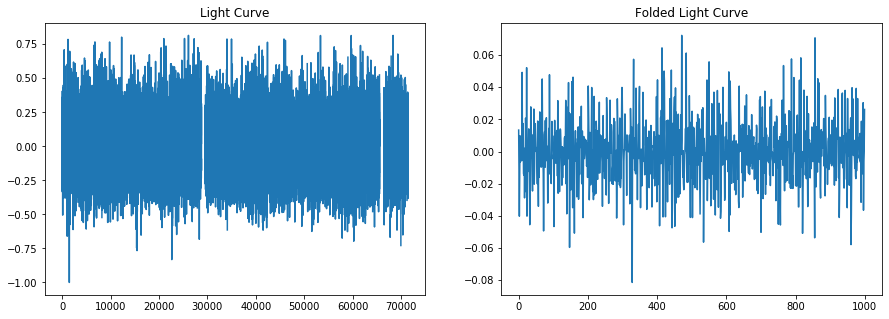

Cantidad de tramos:  832
Largo promedio de tramos:  77.18870192307692
Mediana de largo de tramos:  74.5
Min de largo de tramos:  2
Max de largo de tramos:  149


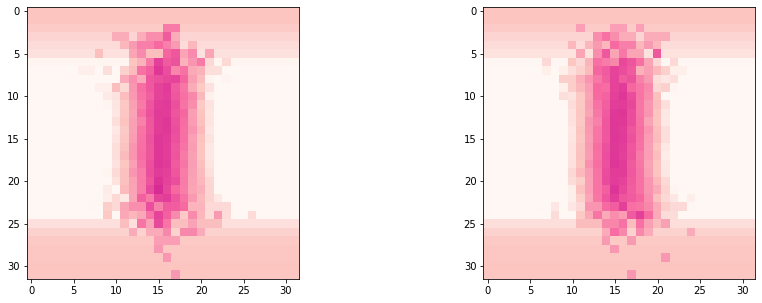

Restoring Curve 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


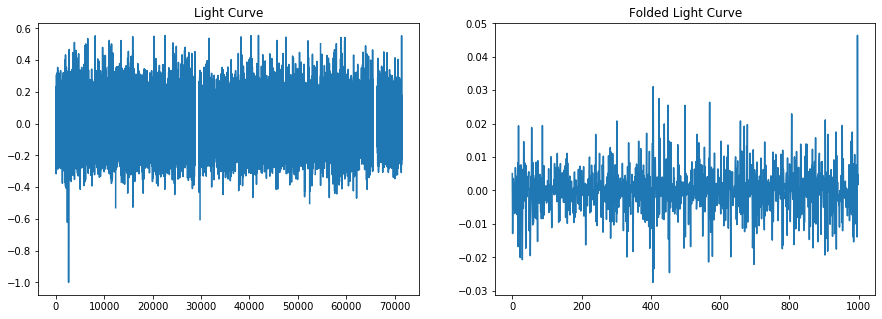

Cantidad de tramos:  816
Largo promedio de tramos:  78.71813725490196
Mediana de largo de tramos:  77.5
Min de largo de tramos:  2
Max de largo de tramos:  149


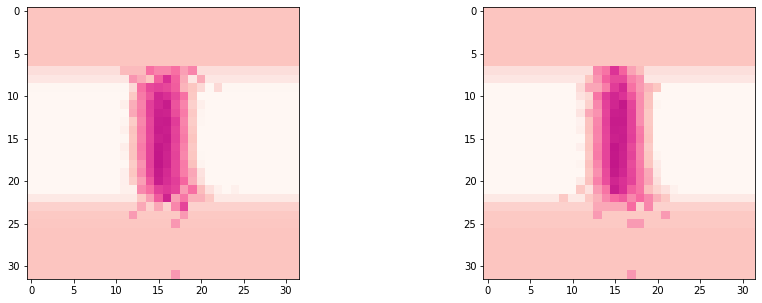

Restoring Curve 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


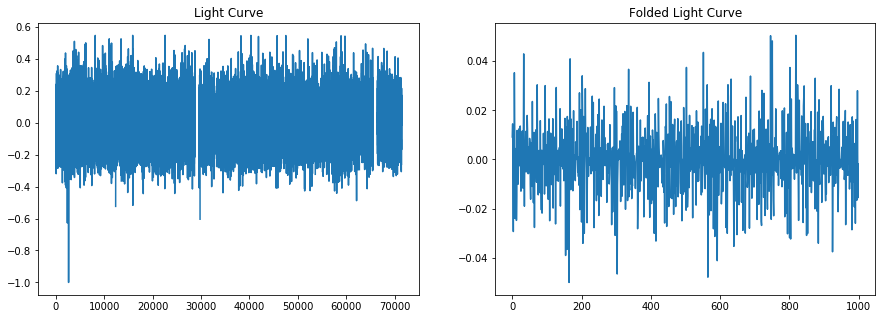

Cantidad de tramos:  1017
Largo promedio de tramos:  57.3913470993117
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


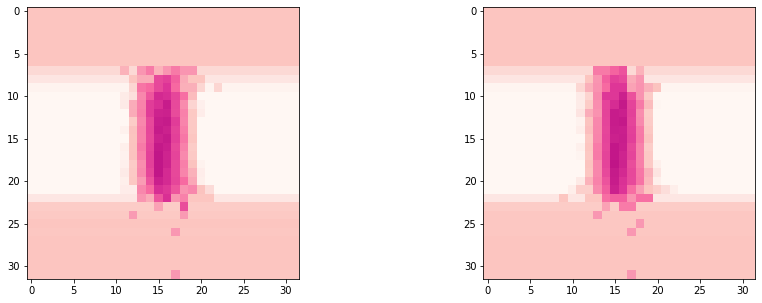

In [45]:
from matplotlib.colors import LogNorm


i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("Restoring Curve",i+1)
    fluxs = prepare_lc(lc_our_detrend) 
    lc_tramos =  extract_nans(fluxs) 
    
    per, t0 = df_aux[["Period", "Time of Transit Epoch"]].values[index_fp][i]
    mask_v = ~np.isnan(fluxs)
    f_glo = global_fold(time_kepler[index_fp][i][mask_v], fluxs[mask_v], per, t0)
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    axx[0].plot(fluxs)
    axx[0].set_title("Light Curve")
    axx[1].plot(f_glo)
    axx[1].set_title("Folded Light Curve")
    plt.show()
    del mask_v,f_glo
    gc.collect()

    transition_m = manual_HMM(lc_tramos, n_sta_up=16, n_sta_low=16) 

    i+=1
    
    labels_x = [str(value) for value in np.arange(0,transition_m.shape[0],2)]
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    axx[0].imshow(transition_m, cmap='RdPu',norm=LogNorm(vmin=0.01, vmax=1)) 
    #axx[0].set_xticklabels(labels_x)
    #axx[0].set_yticklabels(labels_x)

    fluxs = prepare_lc(lc_our_detrend[::-1]) 
    lc_tramos =  extract_nans(fluxs) 
    transition_m = manual_HMM(lc_tramos, n_sta_up=16, n_sta_low=16) 
    
    axx[1].imshow(transition_m, cmap='RdPu',norm=LogNorm(vmin=0.01, vmax=1)) 
    #axx[1].set_xticklabels(labels_x)
    #axx[1].set_yticklabels(labels_x)
    
    plt.show()

As we can see, a great variety of MTF images of the light curve is generated, concluding that there are different types of transition or variable stars in the light curve and this distinction is refined in the different forms of the image. If you wonder why there are two MTF plots, it is because to increase the training data of the networks, we perform a data augmentation by generating another MTF image taking the inverted light curve, therefore, we have an MTF of the curve from "left to right" and another from "right to left", thus allowing us to double the training data. Finally, the following code was used to iterate over the different curves and generate the MTF images

In [ ]:
ups=[16,32,64]
downs=[16,32,64] 

In [ ]:
for arriba in ups:
    for abajo in downs:
        matrices=[]
        i=0
        for lc_our_detrend in our_process: 
            fluxs = prepare_lc(lc_our_detrend)
            lc_tramos =  extract_nans(fluxs, plot=False) 
            transition_m = manual_HMM(lc_tramos, n_sta_up=arriba, n_sta_low=abajo)
            i+=1
            matrices.append(transition_m)

        matrices = np.asarray(matrices)

        folder2 = "./destination_folder/normal_mtf/"
        np.save(folder2+'MTF_u'+str(arriba)+"_d"+str(abajo)+".npy", matrices)

In [ ]:
for arriba in ups:
    for abajo in downs:
        matrices=[]
        i=0
        for lc_our_detrend in our_process: 
            fluxs = prepare_lc(lc_our_detrend[::-1]) #divide by min\n",
            lc_tramos =  extract_nans(fluxs, plot=False) #extract nans\n",
            transition_m = manual_HMM(lc_tramos, n_sta_up=arriba, n_sta_low=abajo) #si se dejan 5 arriba y 10 abajo cambia harto...\n",
            i+=1
            matrices.append(transition_m)

        matrices = np.asarray(matrices)

        folder2 = "./destination_folder/augmented_mtf/"
        np.save(folder2+'MTF_u'+str(arriba)+"_d"+str(abajo)+".npy", matrices)

## Sample Detection Curve and Time MTF

Now that we have the first channel of our image, which belongs to the light curve information, we need to generate a second channel that represents the temporal information of the curve, for this, we will generate another time series called **Sample Detection Curve (SDC)**.

The SDC is the extraction of the temporal information from the sampling of the light curve, to generate this curve a new time series (SDC) was created where the first data x_0 starts at 0 and when iterating the original light curve, each subsequent data in the SDC equals the amount of data found in a continuous series of data on the light curve. When a NaN is found in the original light curve, the value of x_i returns to 0, restarting the process described above. Now, lest make our SDC.

In [46]:
#LoadData
lc_kepler = np.load('/work/work_teamEXOPLANET/KOI_LC/npy/KOI_LC_init.npy')
lc_kepler_times = np.load('/work/work_teamEXOPLANET/KOI_LC/npy/KOI_LC_time.npy')

In [47]:
from math import isnan

total_time_list = []
for lc,times in zip(lc_kepler[:10],lc_kepler_times[:10]):
    time_list = []
    aux_t = times[0]
    for i, data in enumerate(lc):
        if not isnan(data):
            time_list.append(times[i] - aux_t)
        else:
            time_list.append(np.nan)
            #time_list.append(0)
            if (times[i] != times[-1]):
                aux_t = times[i+1]
    total_time_list.append(time_list)

In the following images, we can see how a SDC is generated with the first 200 data points of a light curve, as well as how the algorithm reacts to NaN.

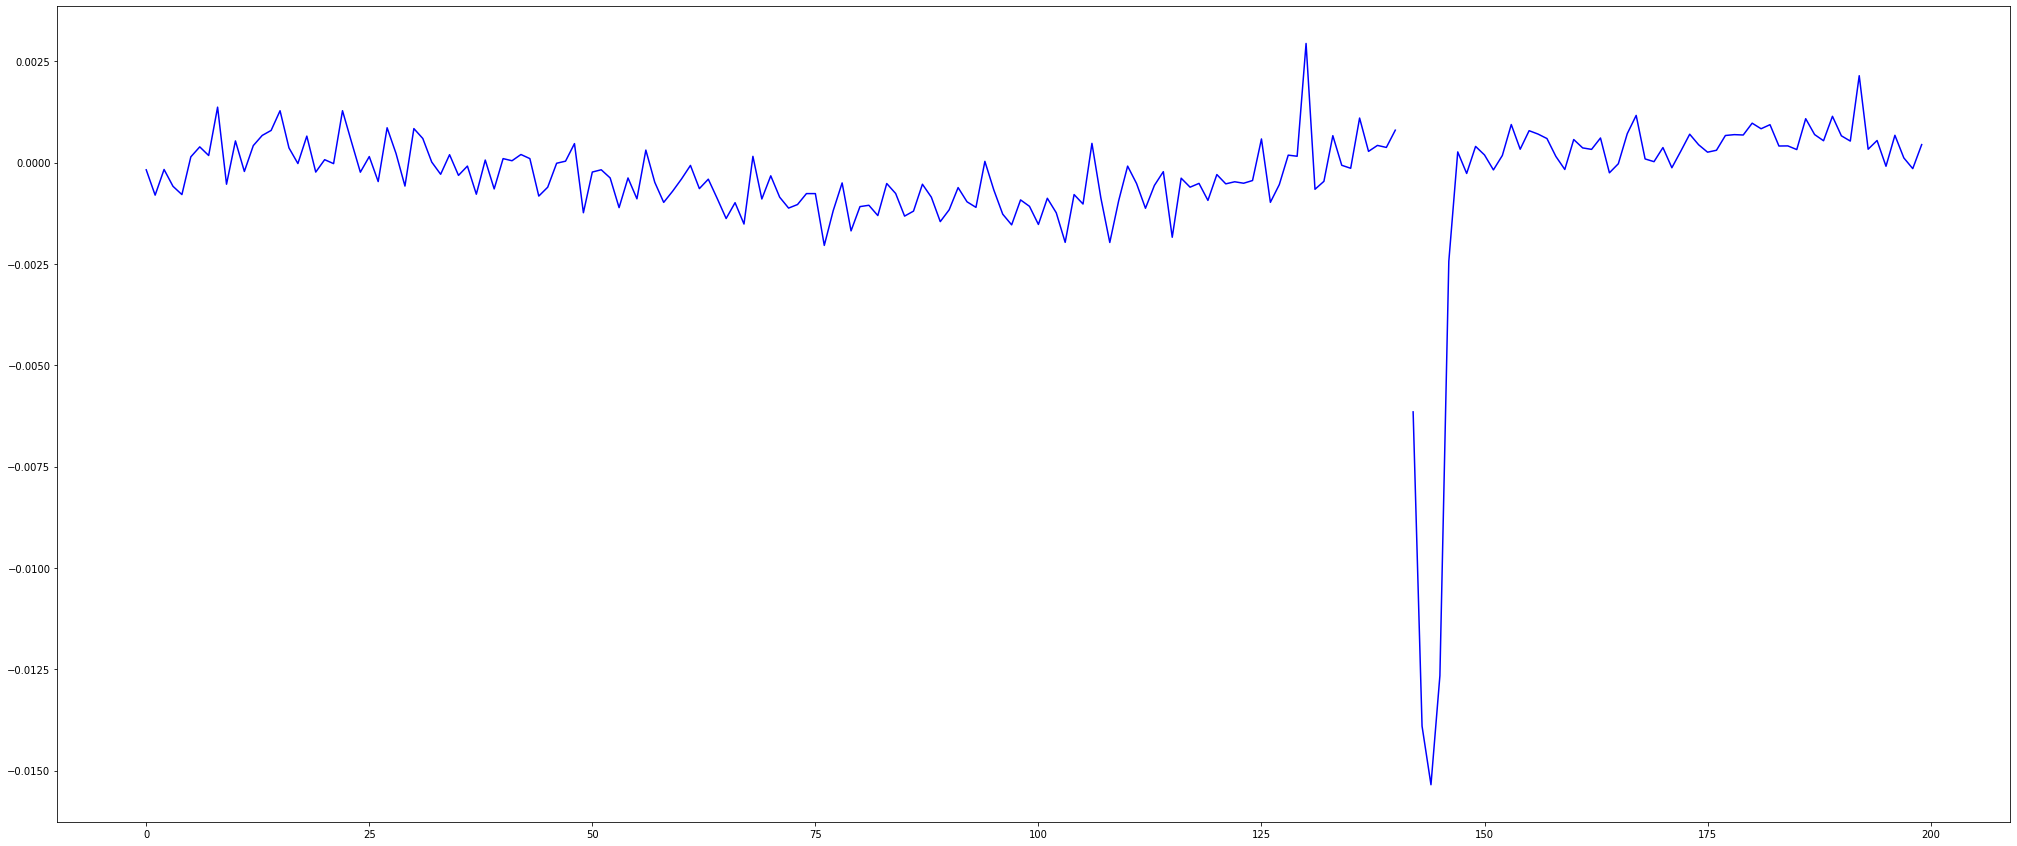

In [48]:
indice = 0
plt.figure(figsize=(35,15))
plt.plot(lc_kepler[indice][:200],'b-')
plt.show()

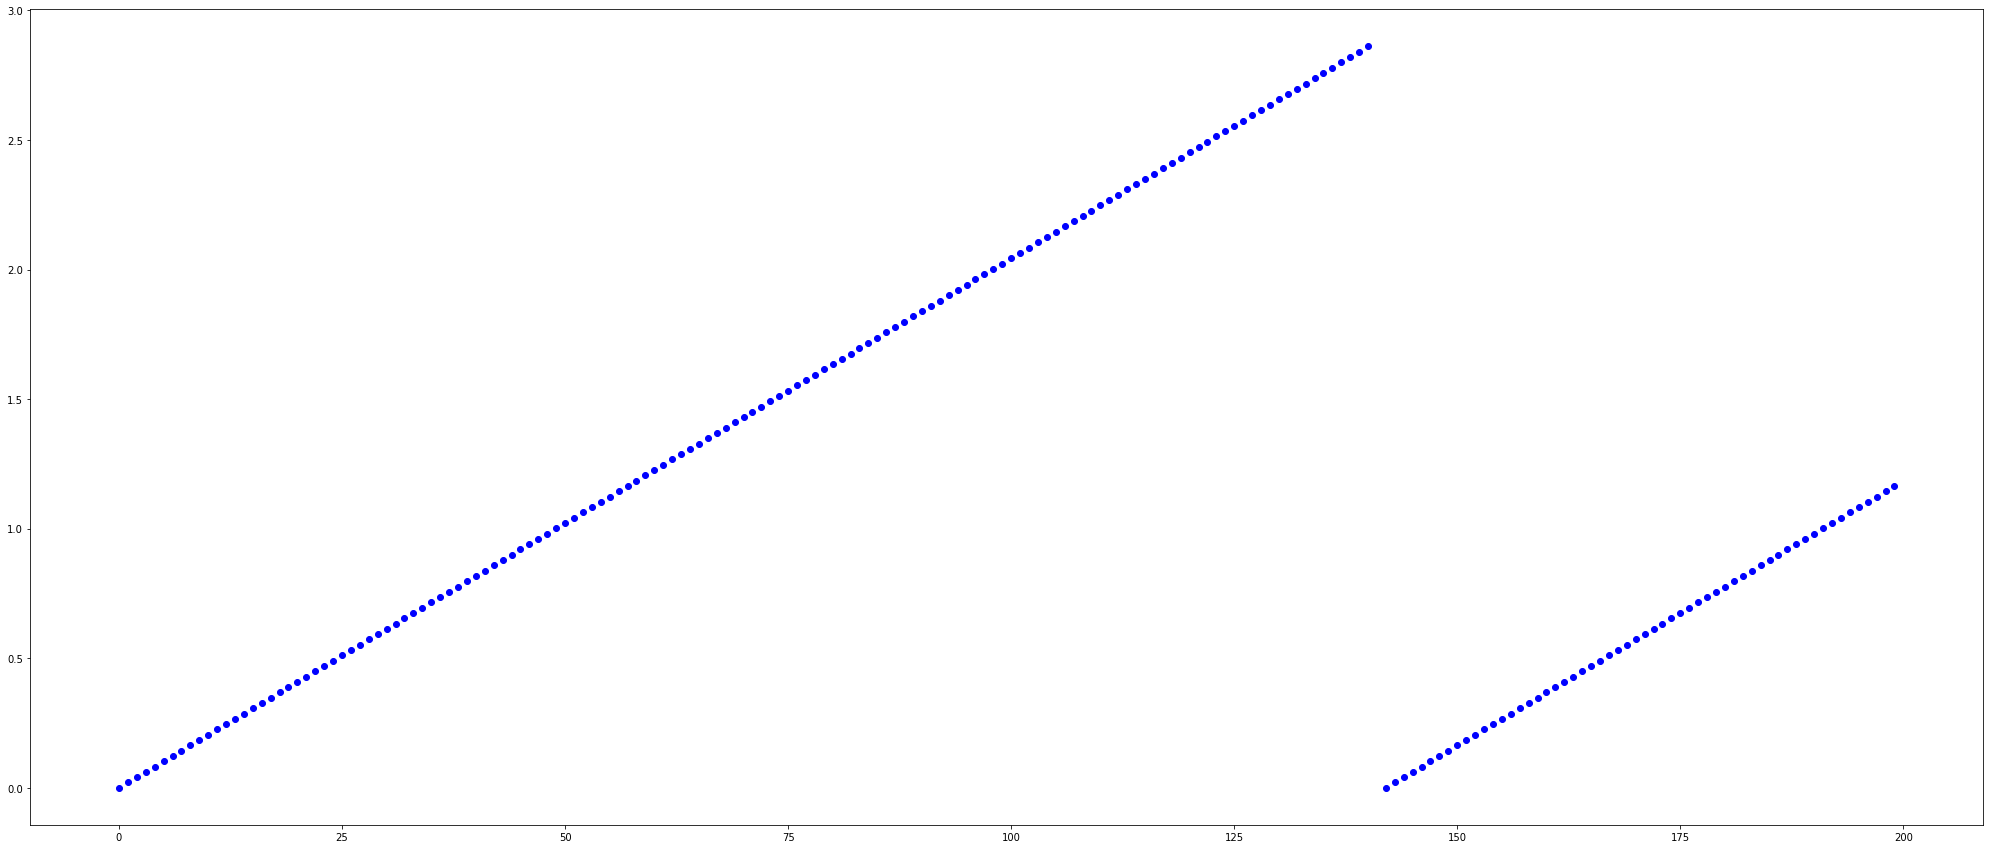

In [49]:
indice = 0
plt.figure(figsize=(35,15))
plt.plot(total_time_list[indice][:200],'bo')
plt.show()

In [50]:
from sklearn.preprocessing import MinMaxScaler

def prepare_lc(fluxs): 
    fluxs = np.asarray(fluxs)
    fluxs = fluxs.reshape(-1,1)
    scaler = MinMaxScaler((-1, 1))
    scaler.fit(fluxs)
    fluxs = scaler.transform(fluxs)
    fluxs = fluxs.ravel()
    return fluxs


time_ajustada = prepare_lc(total_time_list[indice][:200])

<Figure size 432x288 with 0 Axes>

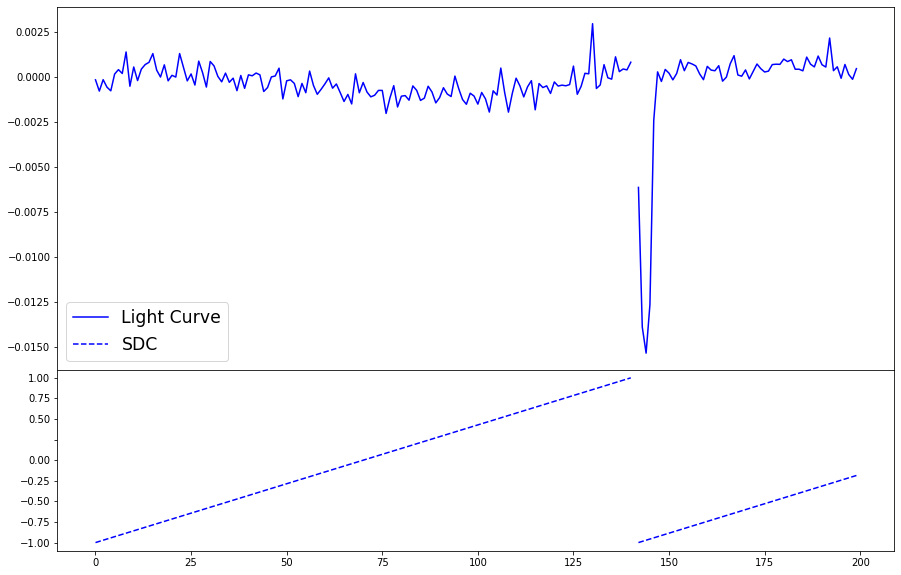

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec


fig = plt.figure()
# set height ratios for sublots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
plt.figure(figsize=(15,10))
# the fisrt subplot
ax0 = plt.subplot(gs[0])
# log scale for axis Y of the first subplot
#ax0.set_yscale("log")
line0, = ax0.plot(lc_kepler[indice][:200], color='b')

#the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
line1, = ax1.plot(time_ajustada, color='b', linestyle='--')
plt.setp(ax0.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)

# put lened on first subplot
ax0.legend((line0, line1), ('Light Curve', 'SDC'), loc='lower left', fontsize = 'xx-large')

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.show()

After generating the SDC, we simply transformed our new time series into another MTF image, which would become the second channel of our total image incorporating the missing temporal information.

# Let's visualize the MTF images

In [3]:
channel_1 = np.load('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u16_d16.npy')  
channel_1_inv = np.load('/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u16_d16.npy')  
channel_3 = np.load('/work/work_teamEXOPLANET/MTF_gabo/npys/MTF_time_u16_d16.npy')  

In [4]:
print(channel_1.shape)
print(channel_1_inv.shape)
print(channel_3.shape)

(8054, 32, 32)
(8054, 32, 32)
(8054, 32, 32)


We proceed to combine the MTF image of the light curve and the MTF image of the SDC, generating two-channel images.

In [5]:
x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_3[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

x_all2 = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1_inv[i],channel_3[i]))
    x_all2.append(combined_image)
x_all2 = np.asarray(x_all2)

In [6]:
x_all.shape

(8054, 32, 32, 2)

We have a total of 8054 MTF images. Now, we will explore this data a bit.

In [7]:
ll = 0
lc_data = channel_1[ll]
time = channel_3[ll]

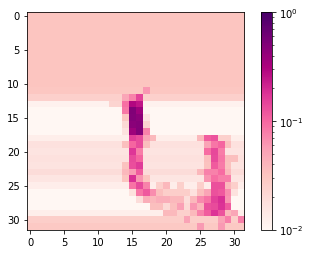

In [8]:
from matplotlib.colors import LogNorm

plt.imshow(lc_data, cmap='RdPu', norm=LogNorm(vmin=0.01, vmax=1)) 
plt.colorbar()
plt.show()

## K Means visualization

In the following code, K means is used to find representative images in the data.

In [52]:
image_vectors = []
for image in channel_1:
    image_vectors.append(image.flatten())
x = np.array(image_vectors)
print(len(x))

8054


In [53]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances_argmin_min

random_state = 44

kmeans_cluster = KMeans(n_clusters=16, random_state=random_state)
kmeans_cluster.fit(x)
y_kmeans = kmeans_cluster.predict(x)
cluster_centers_curva = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

In [54]:
closest, _ = pairwise_distances_argmin_min(cluster_centers_curva, x)
closest

array([ 370, 2614, 3915, 1502, 5957, 1463, 4604, 2341, 1341, 3225, 1431,
       7386, 6123, 6488, 3086, 2984])

Now, we observe how much data each cluster has with only 10 close neighbors and plot the data closest to each centroid generated by Kmeans using Euclidean distance.

In [55]:
unique, counts = np.unique(cluster_labels, return_counts=True)
r_train = dict(zip(unique, counts))
r_train

{0: 295,
 1: 1639,
 2: 145,
 3: 305,
 4: 1543,
 5: 155,
 6: 99,
 7: 97,
 8: 419,
 9: 542,
 10: 141,
 11: 1299,
 12: 184,
 13: 140,
 14: 205,
 15: 846}

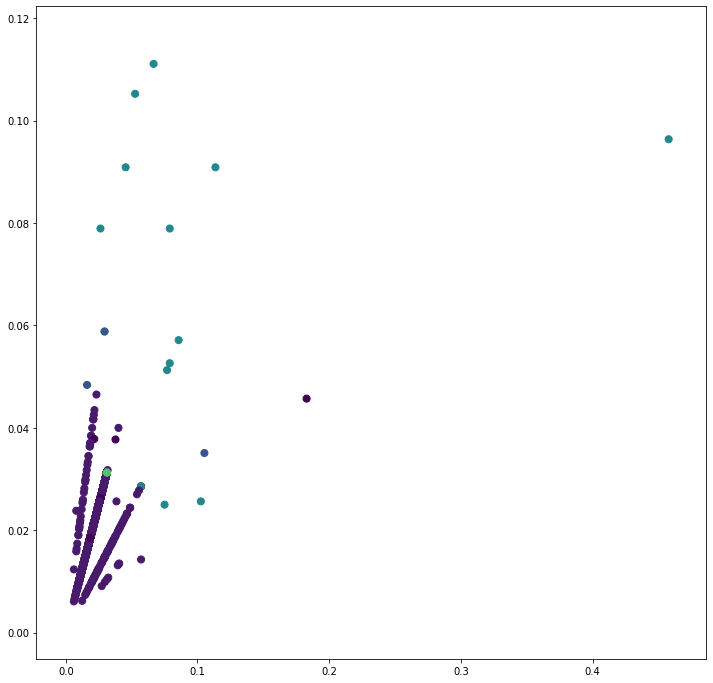

In [56]:
plt.figure(figsize=(12, 12))
plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.show()

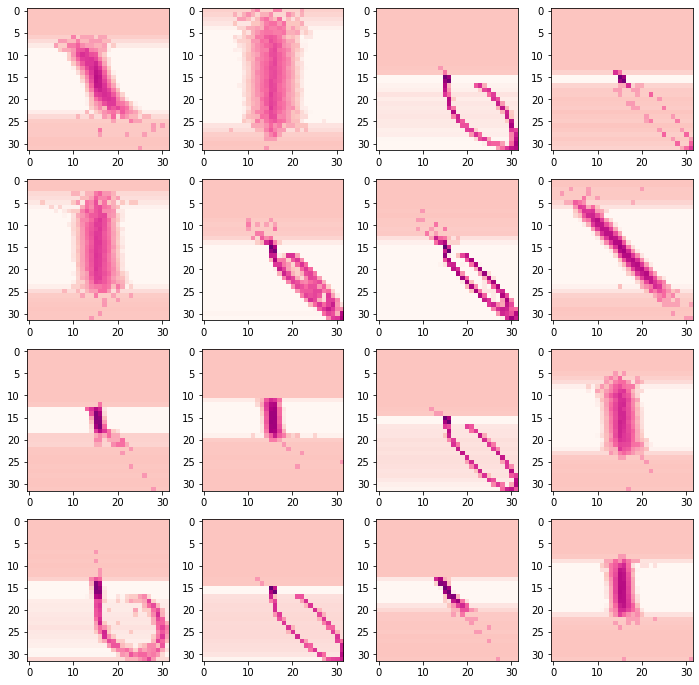

In [58]:
from matplotlib.colors import LogNorm
real_centroid_list = []
plt.figure(figsize=(12, 12))
for centers_index,i in zip(closest, list(range(1,17))):
    plt.subplot(4,4,i)
    plt.imshow(x[centers_index].reshape(32,32), cmap='RdPu', norm=LogNorm(vmin=0.01, vmax=1)) 
    real_centroid_list.append(x[centers_index])

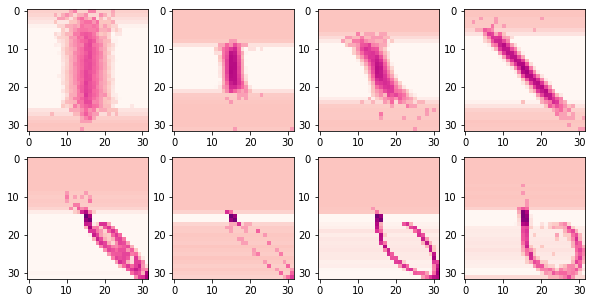

In [74]:
from matplotlib.colors import LogNorm
real_centroid_list = []
plt.figure(figsize=(10, 5))
for centers_index,i in zip([closest[1],closest[-1],closest[0],closest[7],closest[5],closest[3],closest[2],closest[12]], list(range(1,9))):
    plt.subplot(2,4,i)
    plt.imshow(x[centers_index].reshape(32,32), cmap='RdPu', norm=LogNorm(vmin=0.01, vmax=1)) 
    real_centroid_list.append(x[centers_index])

Here we have the 16 centroids of a K means cluster, with this we can see the different types of MTF images that will be generated by the various types of light curves, reaffirming the conclusion that there are several types of transitions present in the curves and that these they are representable through MTF images. Now let's plot the second channel.

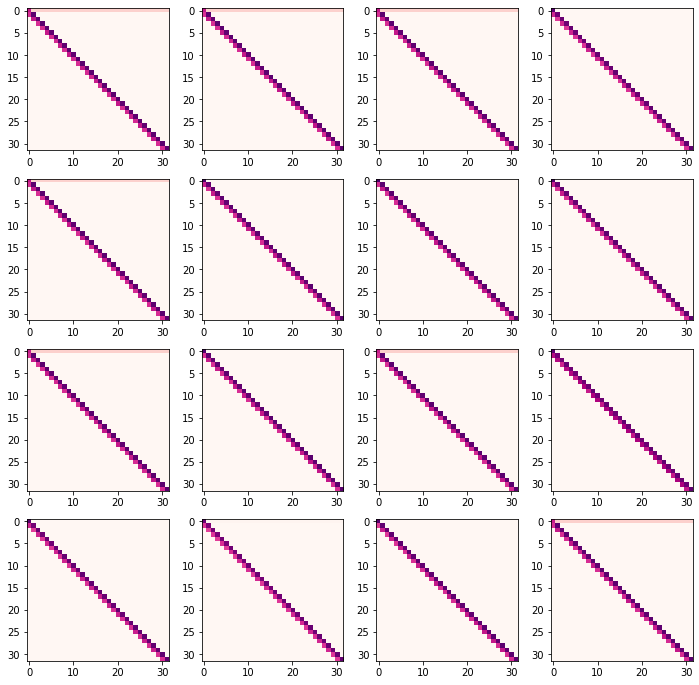

In [75]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(12, 12))
for index,i in zip(closest, list(range(1,17))):
    plt.subplot(4,4,i)
    plt.imshow(channel_3[index], cmap='RdPu', norm=LogNorm(vmin=0.01, vmax=1)) 

The 16 second channel image from the clusters are somewhat similar, this is completely normal because of how the SDC is defined. Despite the fact that the clusters are similar, we can notice certain types of shapes present in the curves, which is why we can say that the temporal information of the sampling if it is represented in this image channel, because we can notice that the The shape of these curves depends on how often the light curve samples were taken, providing certain temporal information. Despite this, let's see how the images look if we make a Kmeans in the time MTF.

We can plot the MTF images in their 2 corresponding channels and, at the same time, place a non-normalized version of their main channel, to visualize the effects of normalization in the image. This normalization has the effect of highlighting certain forms that without it, it would be impossible to observe, guaranteeing that this method is effective for human visualization and therefore, most likely, it also helps the network to find certain important patterns.

In [76]:
no_normalized_mtf = np.load('/work/work_teamEXOPLANET/MTF_gabo/ninv_nn/MTF_u16_d16.npy') 

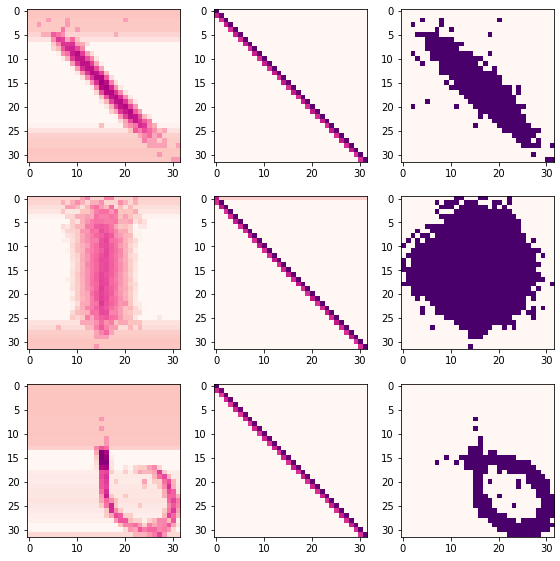

In [77]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(8, 8))
for index,i in zip([closest[7],closest[1],closest[12]], list(range(1,9,3))):
    plt.subplot(3,3,i)
    plt.imshow(channel_1[index].reshape(32,32), cmap='RdPu', norm=LogNorm(vmin=0.01, vmax=1)) 
    plt.subplot(3,3,i+1)
    plt.imshow(channel_3[index], cmap='RdPu', norm=LogNorm(vmin=0.01, vmax=1)) 
    plt.subplot(3,3,i+2)
    plt.tight_layout()
    plt.imshow(no_normalized_mtf[index]>1, cmap='RdPu') 

Now, let's explore what the reverse process will look like, generate a Kmeans in the second channel and use its indexes to plot the data.

In [78]:
image_vectors = []
for image in channel_3:
    image_vectors.append(image.flatten())
x = np.array(image_vectors)
print(len(x))

8054


In [79]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances_argmin_min

random_state = 44

kmeans_cluster = KMeans(n_clusters=16, random_state=random_state)
kmeans_cluster.fit(x)
y_kmeans = kmeans_cluster.predict(x)
cluster_centers_curva = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

In [80]:
closest, _ = pairwise_distances_argmin_min(cluster_centers_curva, x)
closest

array([ 824, 5767, 5564, 4002, 6208, 4137, 4903, 5233, 7145, 4724, 5547,
       2366, 5975, 4190, 7792, 6347])

In [81]:
unique, counts = np.unique(cluster_labels, return_counts=True)
r_train = dict(zip(unique, counts))
r_train

{0: 1325,
 1: 6105,
 2: 4,
 3: 84,
 4: 1,
 5: 2,
 6: 26,
 7: 10,
 8: 3,
 9: 9,
 10: 43,
 11: 2,
 12: 275,
 13: 2,
 14: 1,
 15: 162}

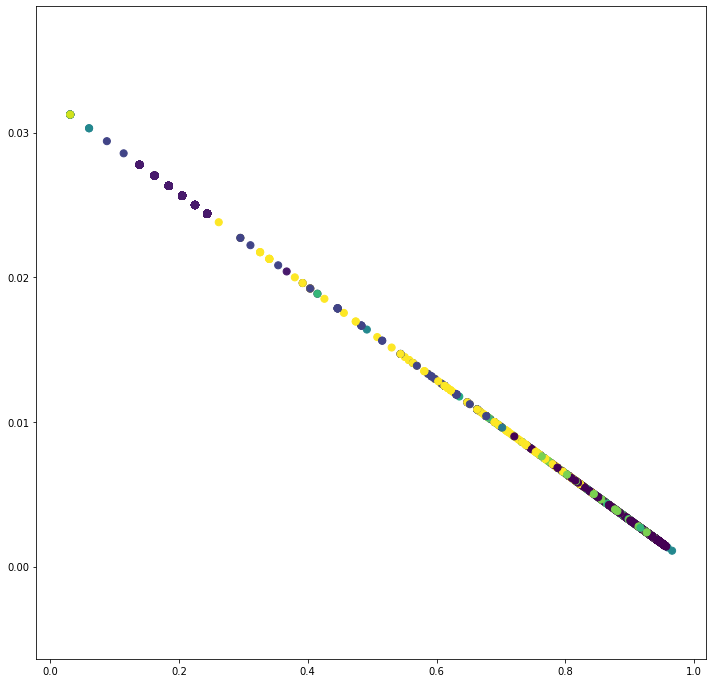

In [82]:
plt.figure(figsize=(12, 12))
plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.show()

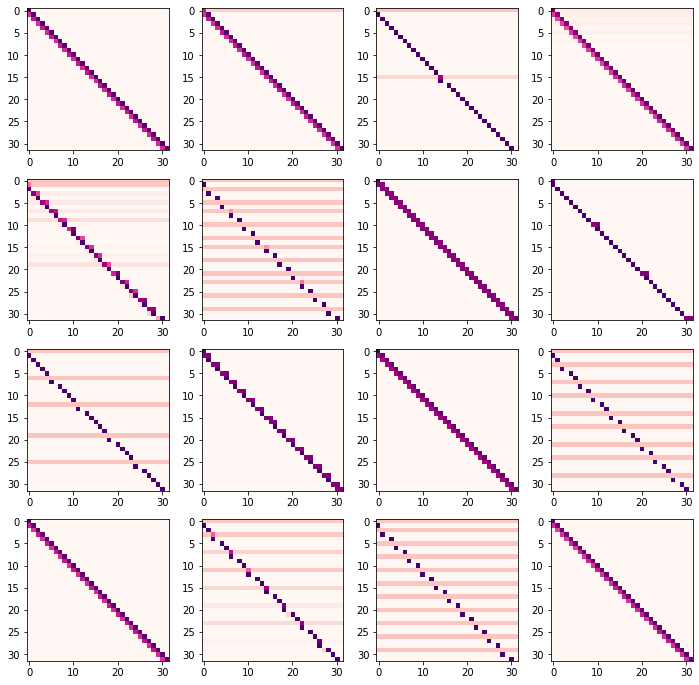

In [83]:
from matplotlib.colors import LogNorm
real_centroid_list = []
plt.figure(figsize=(12, 12))
for centers_index,i in zip(closest, list(range(1,17))):
    plt.subplot(4,4,i)
    plt.imshow(x[centers_index].reshape(32,32), cmap='RdPu', norm=LogNorm(vmin=0.01, vmax=1)) 
    real_centroid_list.append(x[centers_index])

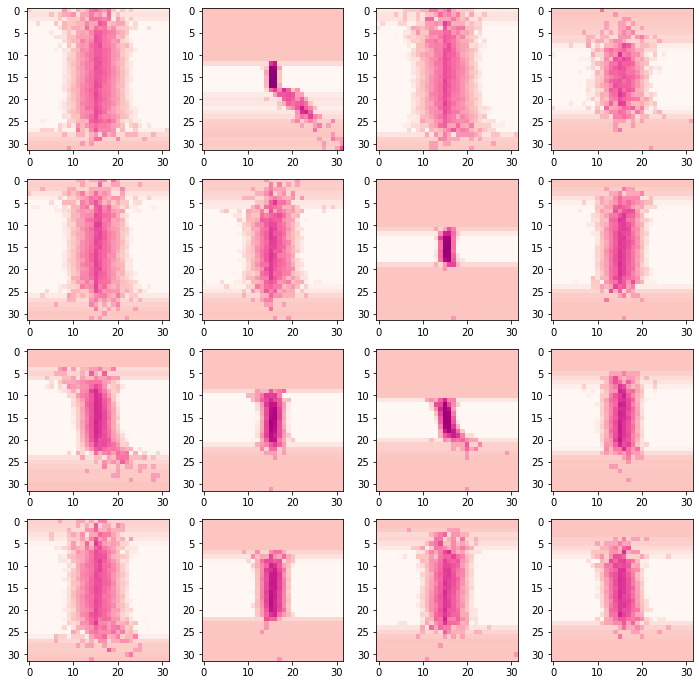

In [35]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(12, 12))
for index,i in zip(closest, list(range(1,17))):
    plt.subplot(4,4,i)
    plt.imshow(channel_1[index], cmap='RdPu', norm=LogNorm(vmin=0.01, vmax=1)) 

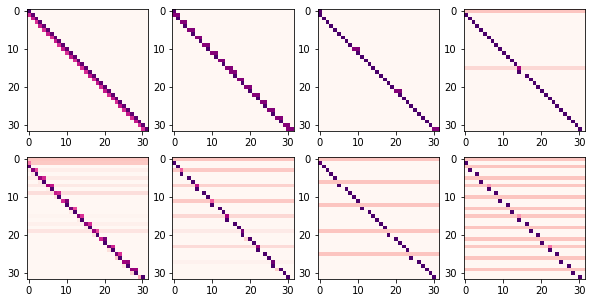

In [93]:
from matplotlib.colors import LogNorm
real_centroid_list = []
plt.figure(figsize=(10, 5))
for centers_index,i in zip([closest[0],closest[9],closest[7],closest[2],closest[4],closest[13],closest[8],closest[5]], list(range(1,9))):
    plt.subplot(2,4,i)
    plt.imshow(x[centers_index].reshape(32,32), cmap='RdPu', norm=LogNorm(vmin=0.01, vmax=1)) 
    real_centroid_list.append(x[centers_index])

When looking for the 16 images closest to their corresponding centroids we can see that certain patterns are formed in the time MTF, this means that if there is certain information and distinction in this channel. Later, when plotting the light curve MTF corresponding to the indexes of the 16 time MTF, we can see that a large part of the light curve MTF are similar, this indicates a high relationship between the type of light curve MTF and the type of time MTF. Finally we plot the non-normalized version to see the difference.

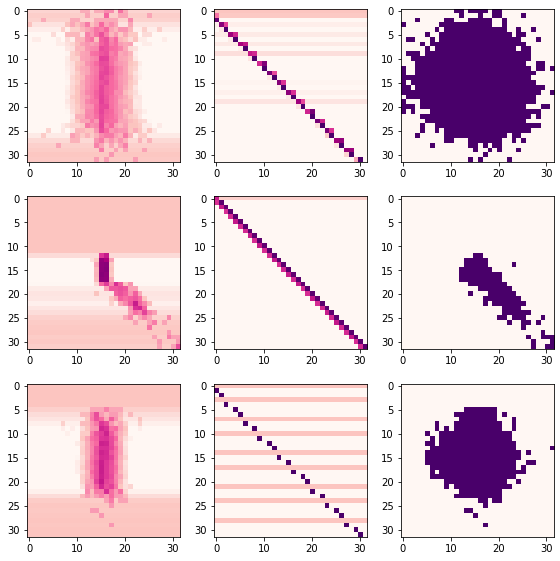

In [42]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(8, 8))
for index,i in zip([closest[4],closest[1],closest[11]], list(range(1,9,3))):
    plt.subplot(3,3,i)
    plt.imshow(channel_1[index].reshape(32,32), cmap='RdPu', norm=LogNorm(vmin=0.01, vmax=1)) 
    plt.subplot(3,3,i+1)
    plt.imshow(channel_3[index], cmap='RdPu', norm=LogNorm(vmin=0.01, vmax=1)) 
    plt.subplot(3,3,i+2)
    plt.tight_layout()
    plt.imshow(no_normalized_mtf[index]>1, cmap='RdPu') 

# CNN Training

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,f1_score, confusion_matrix, mean_absolute_error,mean_squared_error, median_absolute_error
from sklearn.preprocessing import normalize
import time
import matplotlib.pyplot as plt

def plot_df(df):
    try:
        from IPython.display import display
        display(df)
    except:
        print(df)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def calculate_metrics(y_true,y_pred,plot=True, title=""):
    dic_return = {}
    dic_return["Precision raw"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["Recall raw"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Precision"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Recall"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 raw"] = f1_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 weighted"] = f1_score(y_true,y_pred,average="weighted",labels=[0,1])
    dic_return["F1 macro"] = f1_score(y_true,y_pred,average="macro",labels=[0,1])
    dic_return["F1 micro"] = f1_score(y_true,y_pred,average="micro",labels=[0,1])
    matriz=confusion_matrix(y_true,y_pred, labels=[0,1])
    if plot:
        df = pd.DataFrame(dic_return)
        df.index = ["False Positive","Confirmed"]
        plot_df(df)
        plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["False Positive","Confirmed"],title)
    dic_return["Confusion Matrix"] = matriz
    return dic_return


def calculate_median_abs_err(real, pred): 
    if len(real.shape) > 1:
        return np.mean([median_absolute_error(real[:,d],pred[:,d]) for d in range(real.shape[1])])   
    else:
        return median_absolute_error(real,pred)
    
def calculate_mean_abs_perce_err(real, pred):
    diff = np.abs((real - pred) / np.clip(np.abs(real), 1e-7, None))
    return 100. * np.mean(diff) #sin *100 es "fractional"

def calculate_Rmean_squar_log_err(real, pred):
    first_log = np.log(np.clip(pred, 1e-7, None) + 1.)
    second_log = np.log(np.clip(real, 1e-7, None) + 1.)
    return np.sqrt(np.mean(np.square(first_log - second_log)))

def evaluate_metadata(real, pred, plot=False):
    dic_res = {}
    dic_res["MSE"] = mean_squared_error(real, pred)
    dic_res["MAE"] = mean_absolute_error(real, pred)
    dic_res["MeAE"] = calculate_median_abs_err(real, pred)
    dic_res["MApE"] = calculate_mean_abs_perce_err(real,pred)
    dic_res["RMSLE"] = calculate_Rmean_squar_log_err(real,pred)
    if plot:
        df = pd.DataFrame(dic_res)
        df.index = ["Real"]
        plot_df(df)
    return dic_res

def evaluate_metadata_raw(real, pred, plot=True, metadata_used=[""]):
    mse_raw = []
    mae_raw = []
    mEae_raw = []
    maPe_raw = []
    rmsle_raw = []
    for d in range(real.shape[1]):        
        dic_aux = evaluate_metadata(real[:,d], pred[:,d], plot=False)
        mse_raw.append(dic_aux["MSE"])
        mae_raw.append(dic_aux["MAE"])
        mEae_raw.append(dic_aux["MeAE"])
        maPe_raw.append(dic_aux["MApE"])
        rmsle_raw.append(dic_aux["RMSLE"])
        
    res_metadata = {}
    res_metadata["MSE"] = mse_raw
    res_metadata["MAE"] = mae_raw
    res_metadata["MeAE"] = mEae_raw
    res_metadata["MApE"] = maPe_raw
    res_metadata["RMSLE"] = rmsle_raw
    
    if plot:
        df = pd.DataFrame(res_metadata)
        df.index = metadata_used
        df.loc["Global"] = np.mean(df, axis=0)
        plot_df(df.transpose())
    res_metadata["MSE"].append(np.mean(mse_raw))
    res_metadata["MAE"].append(np.mean(mae_raw))
    res_metadata["MeAE"].append(np.mean(mEae_raw))
    res_metadata["MApE"].append(np.mean(maPe_raw))
    res_metadata["RMSLE"].append(np.mean(rmsle_raw))
    return res_metadata

## Generate training and validation set

In [36]:
fold = "./KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

KOI Name        Set
0  K00889.01      Train
1  K01009.01      Train
2  K07621.01       Test
3  K06252.01       Test
4  K00958.01  Unlabeled

In [37]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

KOI Name NExScI Disposition   Kepler Name      Period  \
0   K00889.01          CONFIRMED   Kepler-75 b    8.884923   
1   K01009.01     FALSE POSITIVE           NaN    5.092465   
7   K07622.01     FALSE POSITIVE           NaN   36.267167   
9   K00998.01     FALSE POSITIVE           NaN  161.788327   
10  K00992.01          CONFIRMED  Kepler-745 b    9.931463   

    Time of Transit Epoch  First Transit Time (BJD)  Impact Parameter  \
0              169.991686               2455002.992             0.069   
1              357.535940               2455190.536             0.161   
7              155.081300               2454988.081             0.214   
9              214.039000               2455047.039             0.267   
10             136.491280               2454969.491             0.037   

    Duration  Transit Depth    r/R  ...    Teff  log(g)  Metallicity  \
0    2.07004        16053.4  0.114  ...  5332.0   4.500        -0.08   
1    3.65900          254.0  0.014  ...  5037.0   4.547        -0.20   
7    2.06500          627.1  0.022  ...  4264.0   4.637        -0.20   
9    5.31000        87750.0  0.273  ...  6018.0   4.327         0.18   
10   5.67800          398.6  0.018  ...  5782.0   4.280         0.16   

    Stellar Radius  Stellar Mass  Max single event sigma  \
0            0.843         0.821                  61.291   
1            0.751         0.727                   3.648   
7            0.620         0.607                   3.016   
9            1.212         1.142                 341.666   
10           1.220         1.035                   4.530   

    Max Multievent sigma  Transit Model SNR  KOI count  Transit Number  
0                474.021              388.2          1             153  
1                 15.175               17.1          1             225  
7                  7.472               10.0          1              39  
9                806.993              704.5          1               9  
10                22.901               26.2          2             137  

[5 rows x 31 columns]

In [38]:
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print('y_train distribution: 0:%i   1:%i'%(counts_train[0],counts_train[1]))
print('y_val distribution:   0:%i   1:%i'%(counts_val[0],counts_val[1]))

y_train distribution: 0:2729   1:1610
y_val distribution:   0:1247   1:671


In [40]:
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Training Objects:",x_train.shape, y_train.shape)
print ("Validation Objects:",x_val.shape,y_val.shape)

Training Objects: (4339, 64, 64, 2) (4339,)
Validation Objects: (1918, 64, 64, 2) (1918,)


In [42]:

x_train1 = x_all[mask_train]
x_train2 = x_all2[mask_train]
x_train = np.concatenate([x_train1,x_train2]) #concat

x_val = x_all[mask_test]

if x_train.shape[0] != y_train.shape[0]:
    y_train = np.tile(y_train, (2))
    
print ("Training Objects with augmentation:",x_train.shape, y_train.shape)
print ("Validation Objects:",x_val.shape,y_val.shape)

Training Objects with augmentation: (8678, 64, 64, 2) (8678,)
Validation Objects: (1918, 64, 64, 2) (1918,)


## Training 

In [44]:
import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return

import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128, focal=False,alpha=0.6,gamma = 2,save_f='best_mod.hdf5'):
    if focal:
        aux_model.compile(loss=binary_focal_loss(alpha=alpha, gamma=gamma),optimizer='Adam',metrics=['accuracy'])
    else:
        aux_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    if not focal:
        calls.append(reduce_lr)
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                      callbacks=calls)
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(12,5))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    plt.legend(loc="upper left")
    plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 32)        608       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6272)              0         
__________

7810/7810 [==============================] - 6s 724us/step - loss: 0.4415 - acc: 0.7467 - val_loss: 0.4568 - val_acc: 0.7408
 - val_f1: 0.732016 
Epoch 93/500
7810/7810 [==============================] - 6s 723us/step - loss: 0.4496 - acc: 0.7447 - val_loss: 0.4528 - val_acc: 0.7535
 - val_f1: 0.743622 
Epoch 94/500
7810/7810 [==============================] - 6s 723us/step - loss: 0.4379 - acc: 0.7519 - val_loss: 0.4449 - val_acc: 0.7500
 - val_f1: 0.745211 
Epoch 95/500
7810/7810 [==============================] - 6s 723us/step - loss: 0.4403 - acc: 0.7576 - val_loss: 0.4426 - val_acc: 0.7535
 - val_f1: 0.750140 
Epoch 96/500
7810/7810 [==============================] - 6s 723us/step - loss: 0.4399 - acc: 0.7510 - val_loss: 0.4657 - val_acc: 0.7005
 - val_f1: 0.663405 
Epoch 97/500
7810/7810 [==============================] - 6s 722us/step - loss: 0.4366 - acc: 0.7517 - val_loss: 0.4454 - val_acc: 0.7569
 - val_f1: 0.749326 
Epoch 98/500
7810/7810 [==============================] - 6

7810/7810 [==============================] - 6s 753us/step - loss: 0.3836 - acc: 0.7930 - val_loss: 0.4492 - val_acc: 0.7362
 - val_f1: 0.719606 
Epoch 194/500
7810/7810 [==============================] - 6s 753us/step - loss: 0.3793 - acc: 0.7973 - val_loss: 0.4343 - val_acc: 0.7558
 - val_f1: 0.745535 
Epoch 195/500
7810/7810 [==============================] - 6s 754us/step - loss: 0.3884 - acc: 0.7914 - val_loss: 0.4477 - val_acc: 0.7431
 - val_f1: 0.730301 
Epoch 196/500
7810/7810 [==============================] - 6s 753us/step - loss: 0.3859 - acc: 0.7907 - val_loss: 0.4401 - val_acc: 0.7604
 - val_f1: 0.750810 
Epoch 197/500
7810/7810 [==============================] - 6s 755us/step - loss: 0.3867 - acc: 0.7904 - val_loss: 0.4276 - val_acc: 0.7592
 - val_f1: 0.756420 
Epoch 198/500
7810/7810 [==============================] - 6s 754us/step - loss: 0.4012 - acc: 0.7776 - val_loss: 0.4297 - val_acc: 0.7592
 - val_f1: 0.755501 
Epoch 199/500
7810/7810 [=============================

 - val_f1: 0.761751 
Epoch 244/500
7810/7810 [==============================] - 6s 740us/step - loss: 0.3744 - acc: 0.7986 - val_loss: 0.4369 - val_acc: 0.7535
 - val_f1: 0.751449 
Epoch 245/500
7810/7810 [==============================] - 6s 744us/step - loss: 0.3850 - acc: 0.7995 - val_loss: 0.4445 - val_acc: 0.7569
 - val_f1: 0.748906 
Epoch 246/500
7810/7810 [==============================] - 6s 771us/step - loss: 0.3826 - acc: 0.7924 - val_loss: 0.4436 - val_acc: 0.7477
 - val_f1: 0.741250 
Epoch 247/500
7810/7810 [==============================] - 6s 753us/step - loss: 0.3621 - acc: 0.8131 - val_loss: 0.4437 - val_acc: 0.7396
 - val_f1: 0.732879 
Epoch 248/500
7810/7810 [==============================] - 6s 746us/step - loss: 0.3649 - acc: 0.8040 - val_loss: 0.4330 - val_acc: 0.7581
 - val_f1: 0.755777 
Epoch 249/500
7810/7810 [==============================] - 6s 728us/step - loss: 0.3535 - acc: 0.8120 - val_loss: 0.4407 - val_acc: 0.7500
 - val_f1: 0.745211 
Epoch 250/500
7810/

7810/7810 [==============================] - 6s 740us/step - loss: 0.3080 - acc: 0.8499 - val_loss: 0.4622 - val_acc: 0.7500
 - val_f1: 0.745211 
Epoch 296/500
7810/7810 [==============================] - 6s 736us/step - loss: 0.3034 - acc: 0.8483 - val_loss: 0.4695 - val_acc: 0.7465
 - val_f1: 0.738526 
Epoch 297/500
7810/7810 [==============================] - 6s 734us/step - loss: 0.3088 - acc: 0.8535 - val_loss: 0.4553 - val_acc: 0.7627
 - val_f1: 0.760536 
Epoch 298/500
7810/7810 [==============================] - 6s 737us/step - loss: 0.3079 - acc: 0.8478 - val_loss: 0.4677 - val_acc: 0.7408095 - acc: 0
 - val_f1: 0.733552 
Epoch 299/500
7810/7810 [==============================] - 6s 735us/step - loss: 0.3280 - acc: 0.8321 - val_loss: 0.4505 - val_acc: 0.7454
 - val_f1: 0.739080 
Epoch 300/500
7810/7810 [==============================] - 6s 730us/step - loss: 0.3168 - acc: 0.8411 - val_loss: 0.4476 - val_acc: 0.7615
 - val_f1: 0.758870 
Epoch 301/500
7810/7810 [=================

7810/7810 [==============================] - 6s 744us/step - loss: 0.2764 - acc: 0.8672 - val_loss: 0.4768 - val_acc: 0.7523
 - val_f1: 0.747720 
Epoch 347/500
7810/7810 [==============================] - 6s 743us/step - loss: 0.2703 - acc: 0.8659 - val_loss: 0.4927 - val_acc: 0.7431
 - val_f1: 0.735287 
Epoch 348/500
7810/7810 [==============================] - 6s 743us/step - loss: 0.2689 - acc: 0.8735 - val_loss: 0.4820 - val_acc: 0.7546
 - val_f1: 0.750822 
Epoch 349/500
7810/7810 [==============================] - 6s 741us/step - loss: 0.2666 - acc: 0.8673 - val_loss: 0.5340 - val_acc: 0.7339
 - val_f1: 0.722862 
Epoch 350/500
7810/7810 [==============================] - 6s 733us/step - loss: 0.3020 - acc: 0.8547 - val_loss: 0.5033 - val_acc: 0.7500
 - val_f1: 0.743803 
Epoch 351/500
7810/7810 [==============================] - 6s 731us/step - loss: 0.2818 - acc: 0.8599 - val_loss: 0.5033 - val_acc: 0.7523
 - val_f1: 0.745194 
Epoch 352/500
7810/7810 [=============================

7810/7810 [==============================] - 6s 774us/step - loss: 0.2141 - acc: 0.9017 - val_loss: 0.6365 - val_acc: 0.7189
 - val_f1: 0.704747 
Epoch 449/500
7810/7810 [==============================] - 6s 769us/step - loss: 0.2797 - acc: 0.8718 - val_loss: 0.5430 - val_acc: 0.7477
 - val_f1: 0.742526 
Epoch 450/500
7810/7810 [==============================] - 6s 770us/step - loss: 0.2329 - acc: 0.8969 - val_loss: 0.5482 - val_acc: 0.7442
 - val_f1: 0.738554 
Epoch 451/500
7810/7810 [==============================] - 6s 772us/step - loss: 0.2349 - acc: 0.8963 - val_loss: 0.5467 - val_acc: 0.7396
 - val_f1: 0.733079 
Epoch 452/500
7810/7810 [==============================] - 6s 772us/step - loss: 0.2220 - acc: 0.9027 - val_loss: 0.5755 - val_acc: 0.7442
 - val_f1: 0.739085 
Epoch 453/500
7810/7810 [==============================] - 6s 769us/step - loss: 0.2322 - acc: 0.8949 - val_loss: 0.5647 - val_acc: 0.7431
 - val_f1: 0.735712 
Epoch 454/500
7810/7810 [=============================

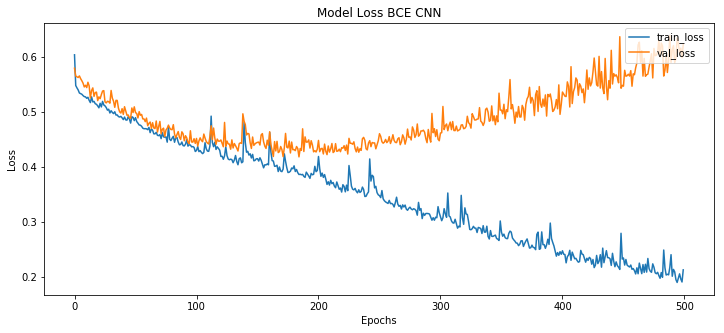

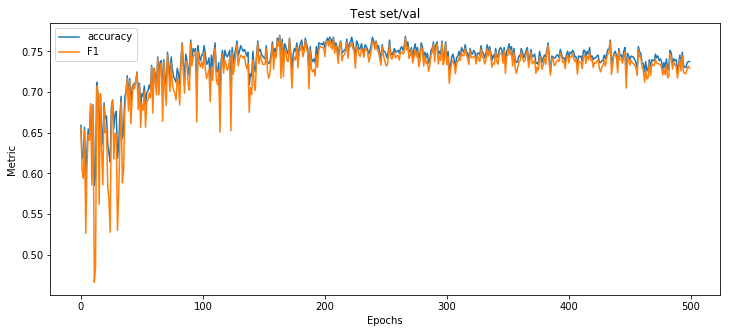

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.838898    0.805934  0.822086     0.774923  0.754681   
Confirmed            0.663889    0.712370  0.687275     0.774923  0.754681   

                F1 micro  
False Positive  0.773201  
Confirmed       0.773201

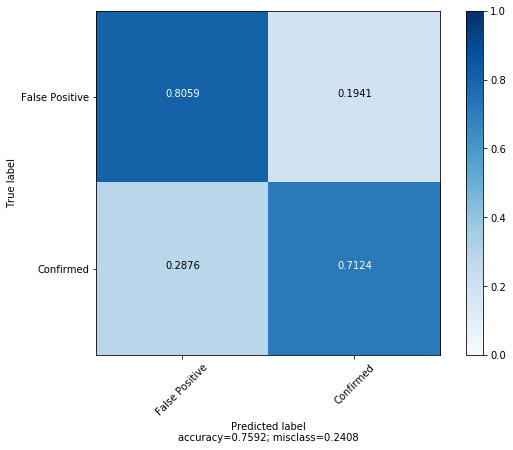

{'Confusion Matrix': array([[1005,  242],
        [ 193,  478]], dtype=int64),
 'F1 macro': 0.7546806155257506,
 'F1 micro': 0.7732012513034412,
 'F1 raw': array([0.82208589, 0.68727534]),
 'F1 weighted': 0.7749232838520308,
 'Precision raw': array([0.83889816, 0.66388889]),
 'Recall raw': array([0.80593424, 0.7123696 ])}

In [47]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
metrics = Metrics()
mcp_save = ModelCheckpoint('best_mod.hdf5', save_best_only=True, monitor='val_loss', mode='min')
hist=model.fit(x_train, y_train, batch_size=128, epochs=500, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                  callbacks=[metrics,mcp_save])
    
plt.figure(figsize=(12,5))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(hist.history['val_acc'],label="accuracy" )
plt.plot(metrics.val_f1s,label="F1" )
plt.ylabel("Metric")
plt.xlabel('Epochs')
plt.title("Test set/val")
plt.legend(loc="upper left")
plt.show()
   
#keras.losses.binary_focal_loss_fixed = keras.losses.mse
best_model = keras.models.load_model("best_mod.hdf5")
predichos=best_model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

# Conclusions

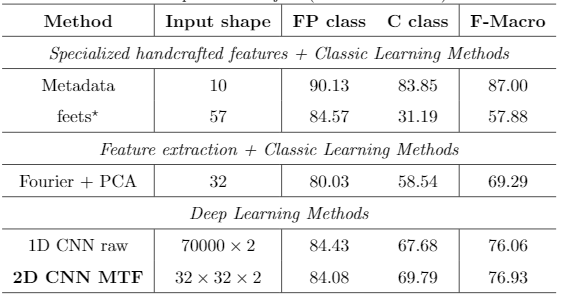

In [175]:
Image(filename ='./Baseline.png')

The following table will discuss the F1 Macro results of the paper. In the paper, the F1 Macro of the proposal is slightly better than the techniques of 1D CNN exceeding it by 0.87%, also, the proposal exceeds by 7.64% the traditional form of classification used by Fourier + PCA and surpassed by 19.05% the feets technique. On the other hand, this proposal is 10.07% worse than the classical techniques baseline with metadata. These results are somewhat ambiguous since, despite having good results on the one hand, it was not possible to overcome the metadata that is the objective of the project, but, when observing the second table, that of execution time, we can see that this proposal it takes around 13 minutes to get results, this includes generating the total MTF image, network training and prediction, while compared to more traditional techniques using metadata it is much faster, going from taking 1 week to have results by metadata to a couple of minutes through this proposal with the sacrifice of decreasing the F1 Macro. On the other hand, this proposal is about 9 minutes slower than Fourier + PCA but it has a better F1 Macro, leaving this proposal as superior if you want to generate the trade-off. Lastly, the 1D CNN deep learning technique tends to take about 6 hours but this proposal takes only 13 minutes on average, demonstrating how fast this proposal is by delivering a quick assessment of whether or not an exoplanet exists on a light.

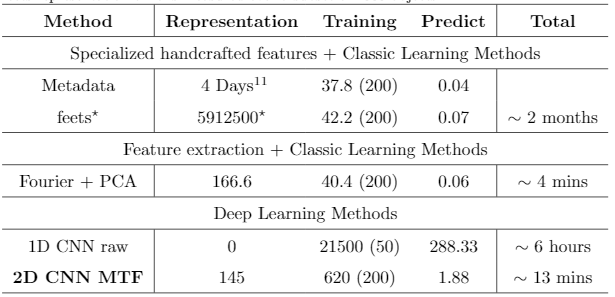

In [174]:
Image(filename ='./Baseline_time.png')

In this proposal, a new technique for detecting exo-planets was presented by raw analysis of light curves transformed into MTF images using Markov Transition Field (MTF). The main objective of this proposal was to defeat the current techniques used on the metadata generated by the Kepler observatory. The results show that this proposal fails to overcome the F1 Macro of the most traditional techniques with metadata, but it is extremely faster in execution time, reducing the time from more than 1 week to a couple of minutes, maintaining a good F1 Macro. Compared to other baselines, it was possible to improve with respect to 1D CNN techniques in both F1 Macro and in runtime, demonstrating that using 2D CNN takes better advantage of the intricate information of light curves.